# H12 locus artwork 

## Setup

In [49]:
%run locus-artwork-setup.ipynb

In [2]:
def plot_h12_percentiles(pop):
    fig, ax = plt.subplots(facecolor='w', figsize=(10, 3))
    
    # plot each chromosome
    x = np.arange(80, 100)
    all_h12s = []
    for c in '2', '3', 'X':
        # load gwss data
        _, _, _, h12, _, _ = load_h12_gwss(pop, c)
        all_h12s.append(h12)
        # plot 
        y = [np.percentile(h12, i) for i in x]
        ax.plot(x, y, marker='o', label=c)
        
    # plot all
    h12 = np.concatenate(all_h12s)
    y = [np.percentile(h12, i) for i in x]
    ax.plot(x, y, marker='o', label='all', color='k', lw=2)

    # tidy
    ax.set_ylim(bottom=0, top=0.4)
    ax.legend(loc='upper left', title='Chromosome')
    ax.set_xticks(x)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('$H12$')
    ax.set_title(pop_defs[pop]['label'])
    
    plt.show()
    plt.close()
    

In [3]:
@functools.lru_cache(maxsize=None)
def get_h12_percentile(pop, q):
    h12s = []
    for c in '2', '3', 'X':
        # load gwss data
        _, _, _, h12, _, _ = load_h12_gwss(pop, c)
        h12s.append(h12)
    h12 = np.concatenate(h12s)
    return np.percentile(h12, q)
    

In [4]:
get_h12_percentile('bf_gam', 99)

0.162943052930056

In [5]:
get_h12_percentile('bf_gam', 98)

0.09913120962352417

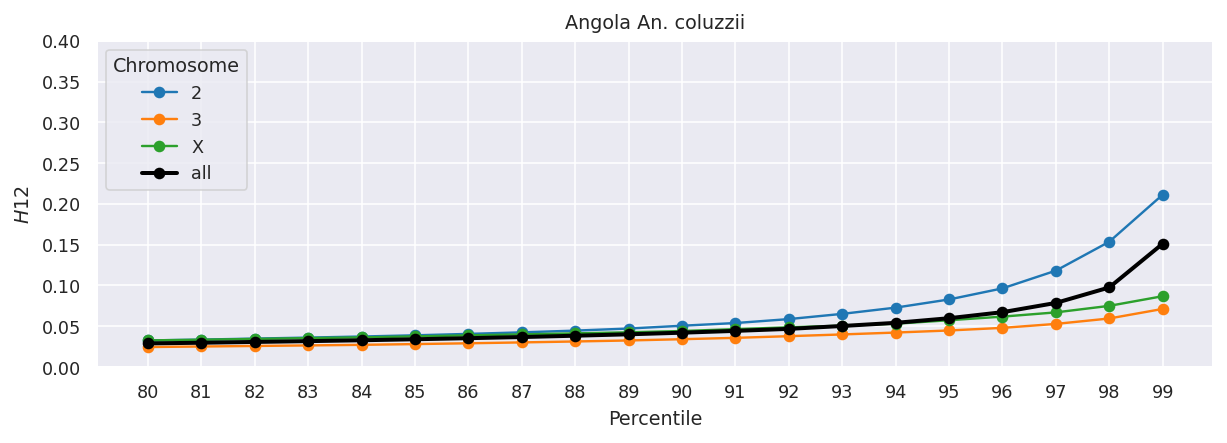

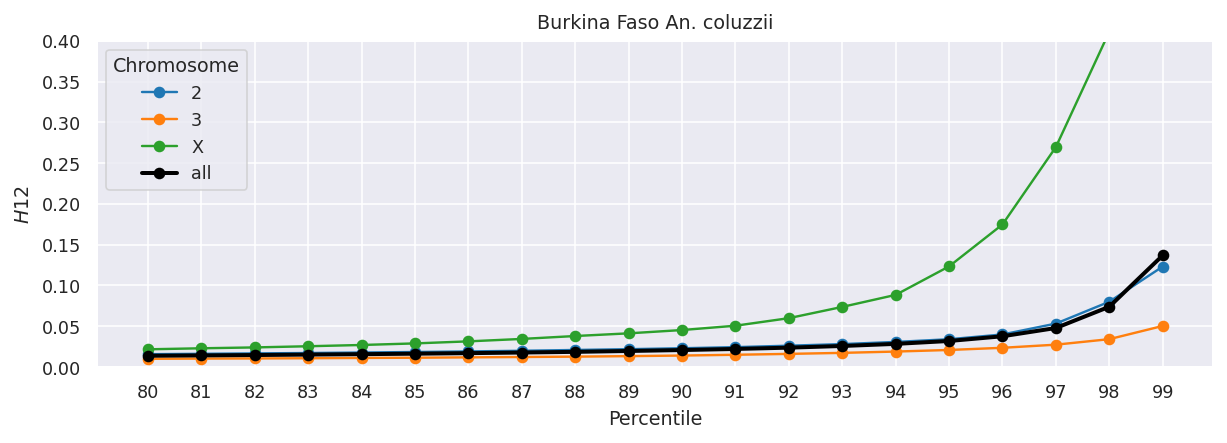

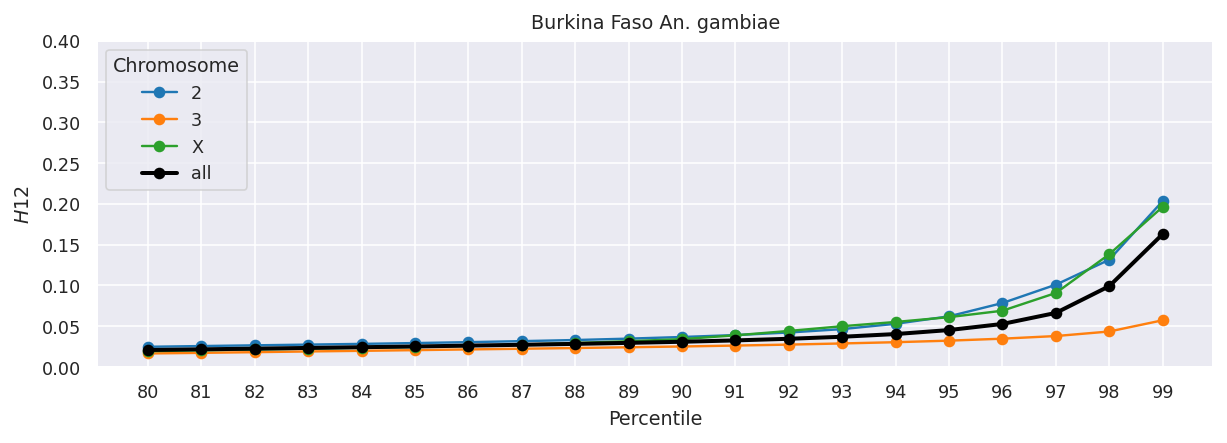

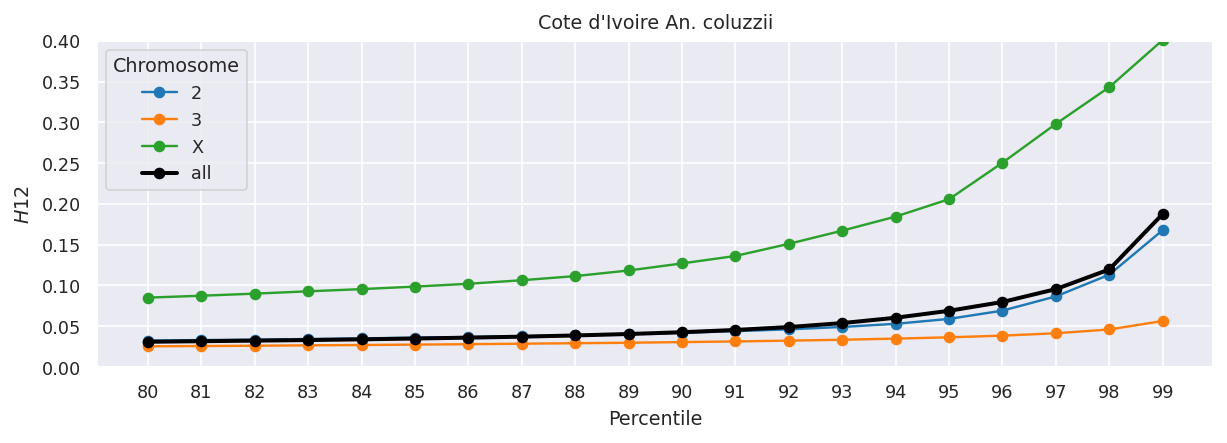

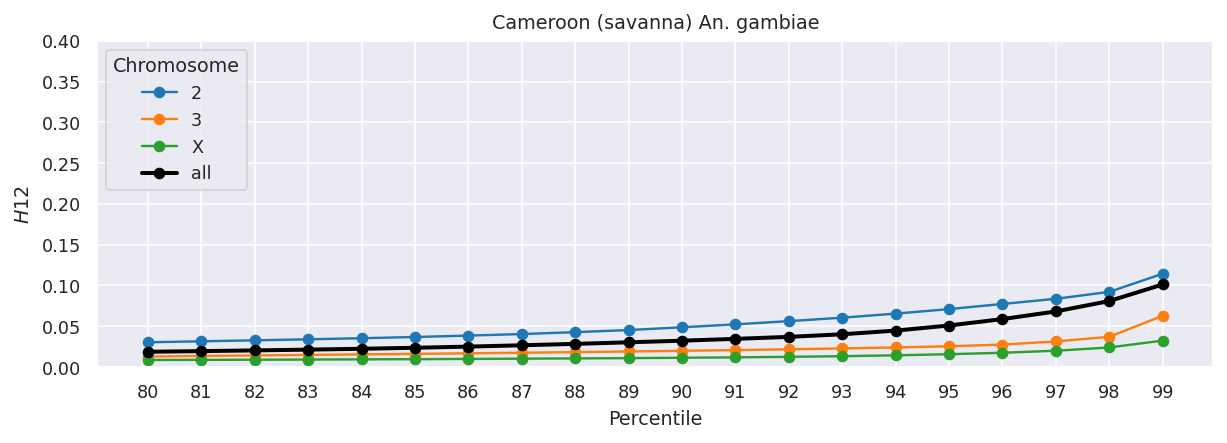

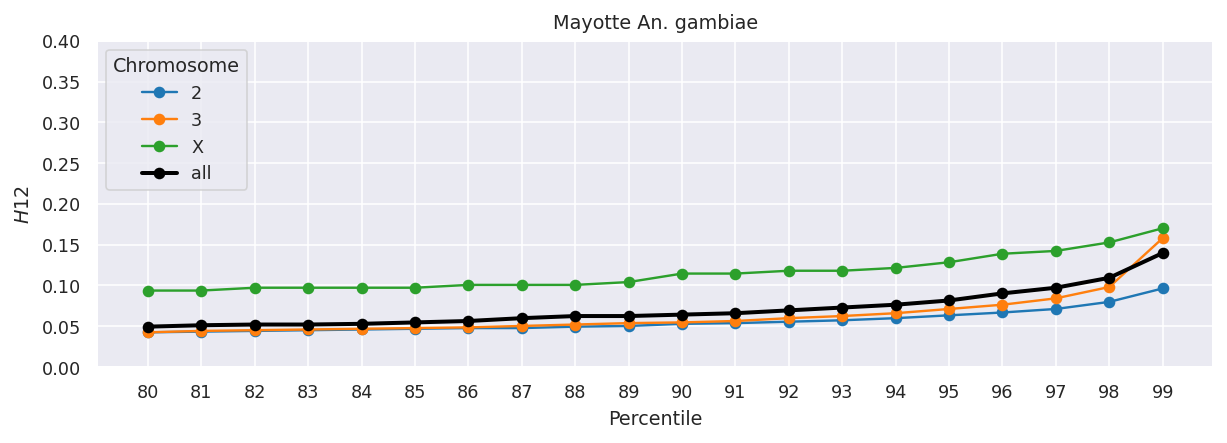

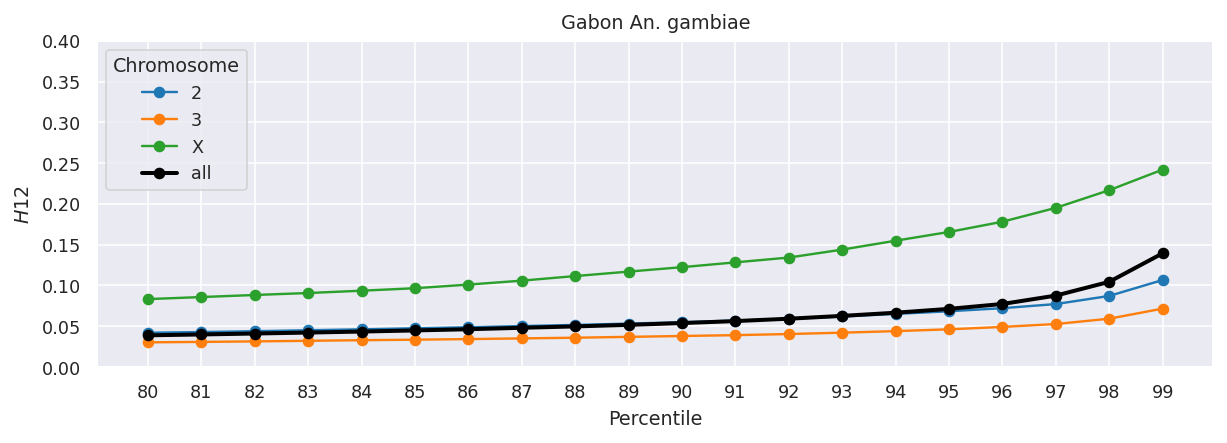

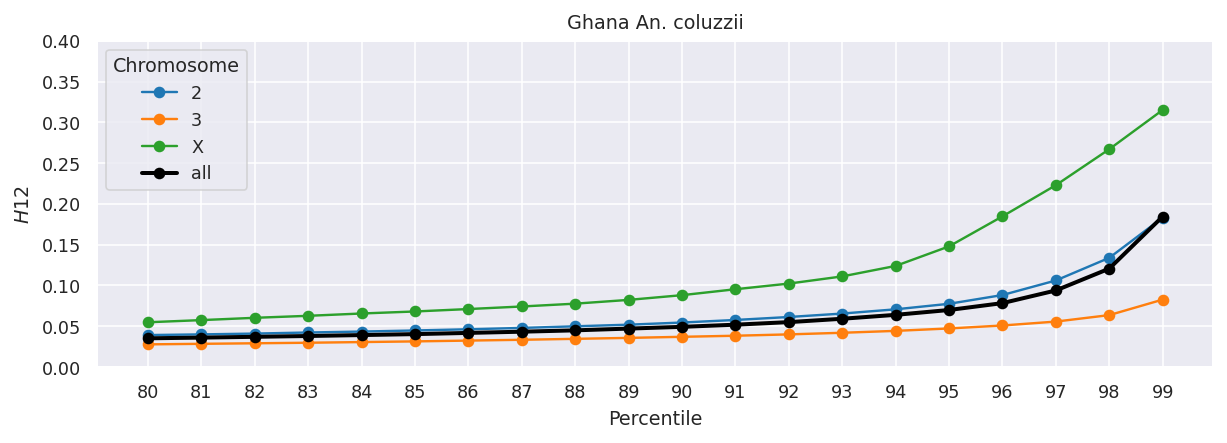

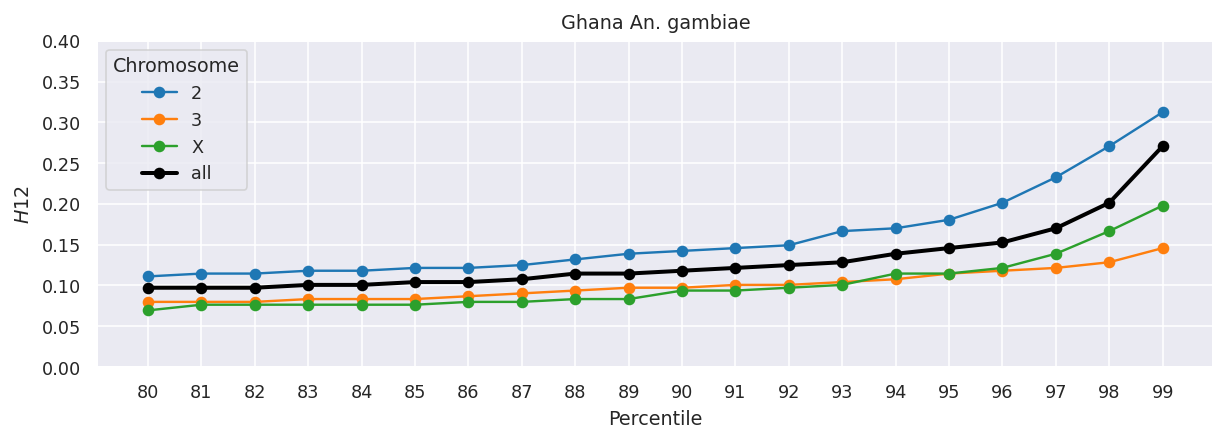

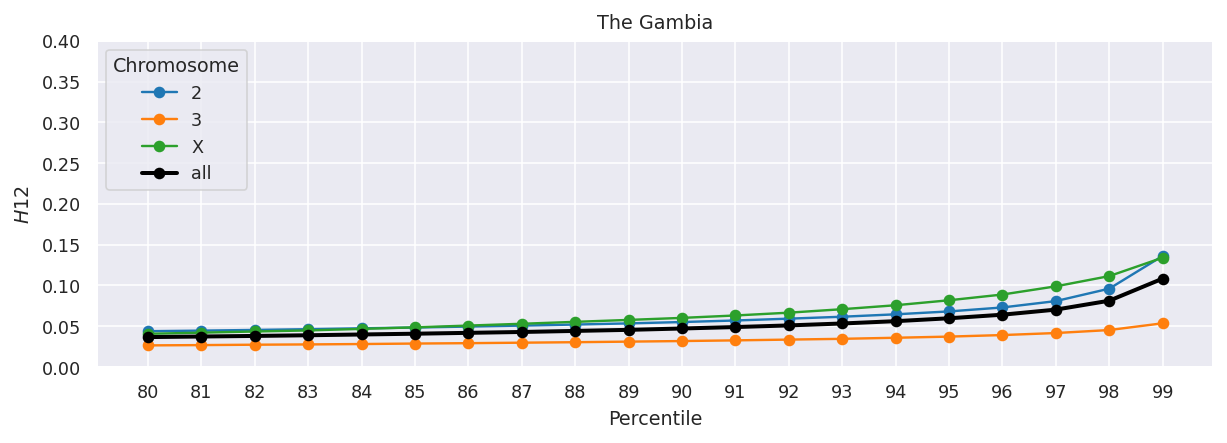

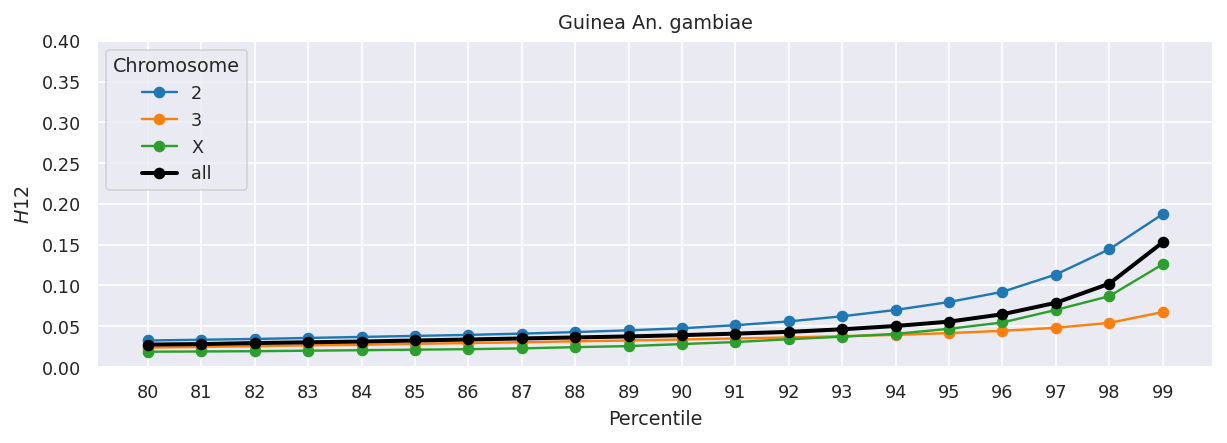

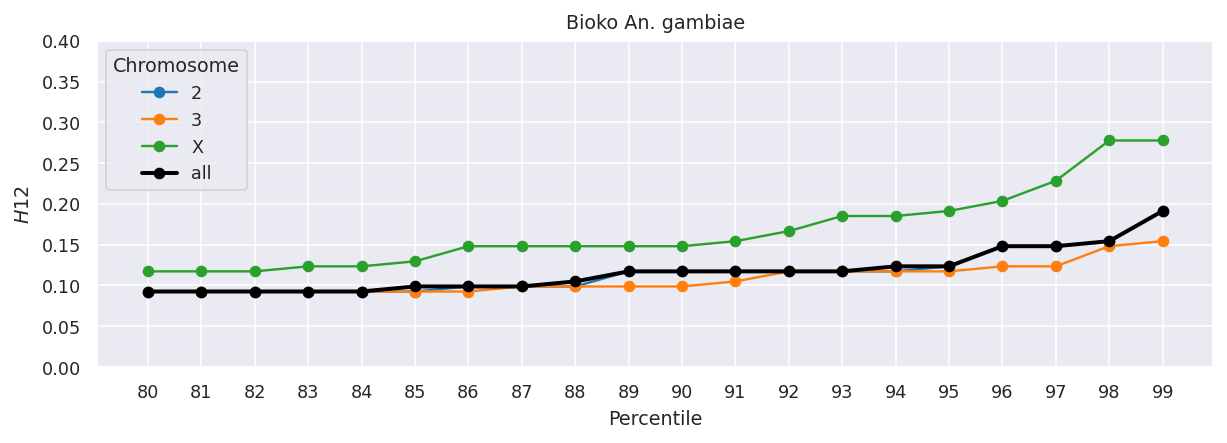

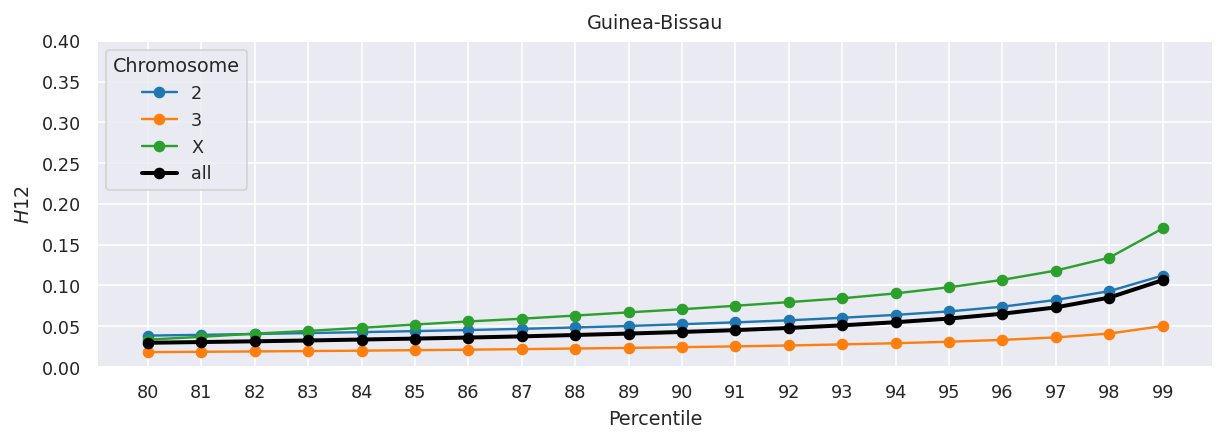

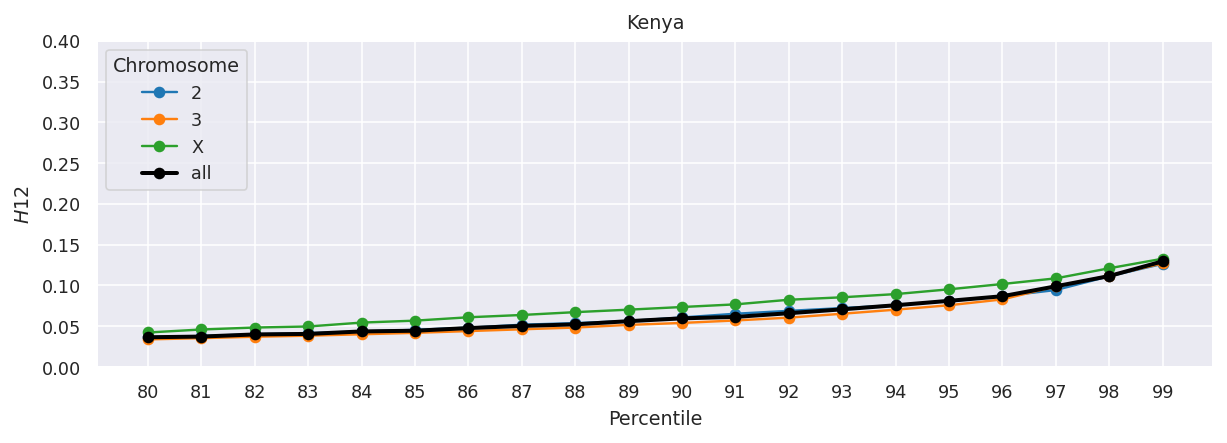

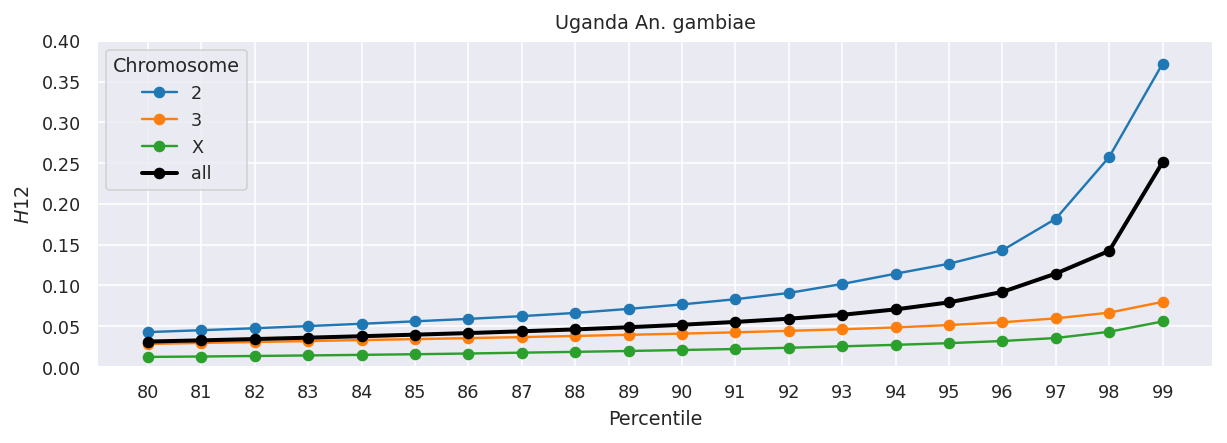

In [6]:
for pop in pop_defs:
    plot_h12_percentiles(pop)

In [63]:
def plot_h12(pop, chromosome, center, flank, ymax=None, ax=None,  
             markersize=2, legend=False, genetic_distance=False, 
             label=True, detail=False,
             median_filter=0, has_peak_n=20, has_peak_dist=.2, 
             percentiles=[98]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
        
    # load gwss data
    windows, gwindows, h1, h12, h123, h2_h1 = load_h12_gwss(pop, chromosome)
    if median_filter:
        h12 = scipy.ndimage.median_filter(h12, size=median_filter, mode='wrap')
    p = windows.mean(axis=1)/1e6
    gp = gwindows.mean(axis=1)
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p
        
    # plot percentiles
    qvals = []
    for q in percentiles:
        v = get_h12_percentile(pop, q)
        qvals.append(v)
        ax.axhline(v, color='gray', linestyle='--', lw=1)
        ax.annotate(f'$P_{{{q}}}$', xy=(xlim[1], v), xytext=(2, 0), xycoords='data', 
                    textcoords='offset points', ha='left', va='center', fontsize=8)
    
    # plot data
    if detail:
        palette = sns.color_palette("Blues_d", 3)
        ax.plot(x, h123, linestyle=' ', marker='o', color=palette[2], 
                markersize=markersize, label='$H123$')
        ax.plot(x, h12, linestyle=' ', marker='o', color=palette[1], 
                markersize=markersize, label='$H12$')
        ax.plot(x, h1, linestyle=' ', marker='o', color=palette[0], 
                markersize=markersize, label='$H1$')
    else:
        palette = sns.color_palette()
        ax.plot(x, h12, linestyle=' ', marker='o', color=palette[0], 
                markersize=markersize, label='$H12$')

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        if detail:
            ymax = max(1.1*qvals[-1], 1.1*np.max(h123[loc_xlim]))
        else:
            ymax = max(1.1*qvals[-1], 1.1*np.max(h12[loc_xlim]))
    ax.set_ylim(0, ymax)
    ax.set_ylabel('$H12$')
    pop_label = (
        pop_defs[pop]["label"]
        .replace('An. gambiae', '$An. gambiae$')
        .replace('An. coluzzii', '$An. coluzzii$')
    )
    
    # statistics
    loc_peak_test = allel.SortedIndex(p).locate_range(center-has_peak_dist, center+has_peak_dist)
    has_peak = np.count_nonzero(h12[loc_peak_test] > qvals[-1]) > has_peak_n
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-.5, center+.5)
        h1_peak = np.max(h1[loc_region])
        h12_peak = np.max(h12[loc_region])
        h123_peak = np.max(h123[loc_region])
        pos_h1_peak = p[loc_region][np.argmax(h1[loc_region])] - center
        pos_h12_peak = p[loc_region][np.argmax(h12[loc_region])] - center
        pos_h123_peak = p[loc_region][np.argmax(h123[loc_region])] - center
        statistics = dict(
            pop=pop,
            h1_peak=h1_peak,
            h12_peak=h12_peak,
            h123_peak=h123_peak,
            pos_h1_peak=pos_h1_peak,
            pos_h12_peak=pos_h12_peak,
            pos_h123_peak=pos_h123_peak
        )
    else:
        statistics = dict(
            pop=pop,
            h1_peak=np.nan,
            h12_peak=np.nan,
            h123_peak=np.nan,
            pos_h1_peak=np.nan,
            pos_h12_peak=np.nan,
            pos_h123_peak=np.nan
        )
    
    if label:
        if has_peak:
            if detail:
                annotation = (
                    f"{pop_label}\n"
                    f"$H123_{{peak}}={h123_peak:.2f}$\n"
                    f"$H12_{{peak}}={h12_peak:.2f}$\n"
                    f"$H1_{{peak}}={h1_peak:.2f}$\n"
                    f"$pos(H12_{{peak}})={pos_h12_peak*1e3:+.1f}$ kbp"
                )
            else:
                annotation = (
                    f"{pop_label}\n"
                    f"$H12_{{peak}}={h12_peak:.2f}$\n"
                    f"$pos(H12_{{peak}})={pos_h12_peak*1e3:+.1f}$ kbp"
                )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xycoords='axes fraction',
                    xytext=(8, -8), textcoords='offset points', 
                    fontsize=8, ha='left', va='top', backgroundcolor='w')
    if detail and legend:
        lgd = ax.legend(bbox_to_anchor=(1, 1), loc='upper right', facecolor='w', edgecolor='w')
        for handle in lgd.legendHandles:
            handle._legmarker.set_markersize(6)
            
    return statistics
    

In [126]:
all_stats = dict()


def analyse_gene(gene, flank=1.5, genetic_distance=False):
    
    # first pass, plot all populations
    df_stats = fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'], track_height=2, 
        genetic_distance=genetic_distance,
        plot_kwargs=dict(ymax=1),
        tracks=(
            (plot_h12, dict(pop='bf_gam')),
            (plot_h12, dict(pop='gn_gam')),
            (plot_h12, dict(pop='gh_gam')),
            (plot_h12, dict(pop='cm_sav_gam')),
            (plot_h12, dict(pop='ug_gam')),
            (plot_h12, dict(pop='ga_gam')),
            (plot_h12, dict(pop='gq_gam')),
            (plot_h12, dict(pop='fr_gam')),
            (plot_h12, dict(pop='bf_col')),
            (plot_h12, dict(pop='ci_col')),
            (plot_h12, dict(pop='gh_col')),
            (plot_h12, dict(pop='ao_col')),
            (plot_h12, dict(pop='gw')),
            (plot_h12, dict(pop='gm')),
            (plot_h12, dict(pop='ke')),
        ),
    )
    plt.show()
    plt.close()
    
    # store stats
    all_stats[gene['Name'].lower()] = df_stats
    
    # find pops with peak
    peak_pops = df_stats[~df_stats.h12_peak.isna()]['pop'].values
    
    if len(peak_pops) < 5:
        track_height = 2
    else:
        track_height = None

    # second pass, plot only pops with a peak
    fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'],
        genetic_distance=genetic_distance,
        track_height=track_height,
        tracks=[(plot_h12, dict(pop=pop)) for pop in peak_pops],
        plot_kwargs=dict(ymax=df_stats['h12_peak'].max()*1.03),
        savefig=here() / f"artwork/locus_{gene['Name'].lower()}_h12_{'g' if genetic_distance else 'p'}dist.png"
    )  
    plt.show()
    plt.close()
    

## *Gste2*

In [127]:
gste2

seqid                            3R
source                   VectorBase
type                           gene
start                      28597652
end                        28598640
score                            -1
strand                            -
phase                            -1
Name                          Gste2
biotype              protein_coding
chromosome                        3
chromosome_start           28597652
chromosome_end             28598640
chromosome_center       2.85981e+07
Name: AGAP009194, dtype: object

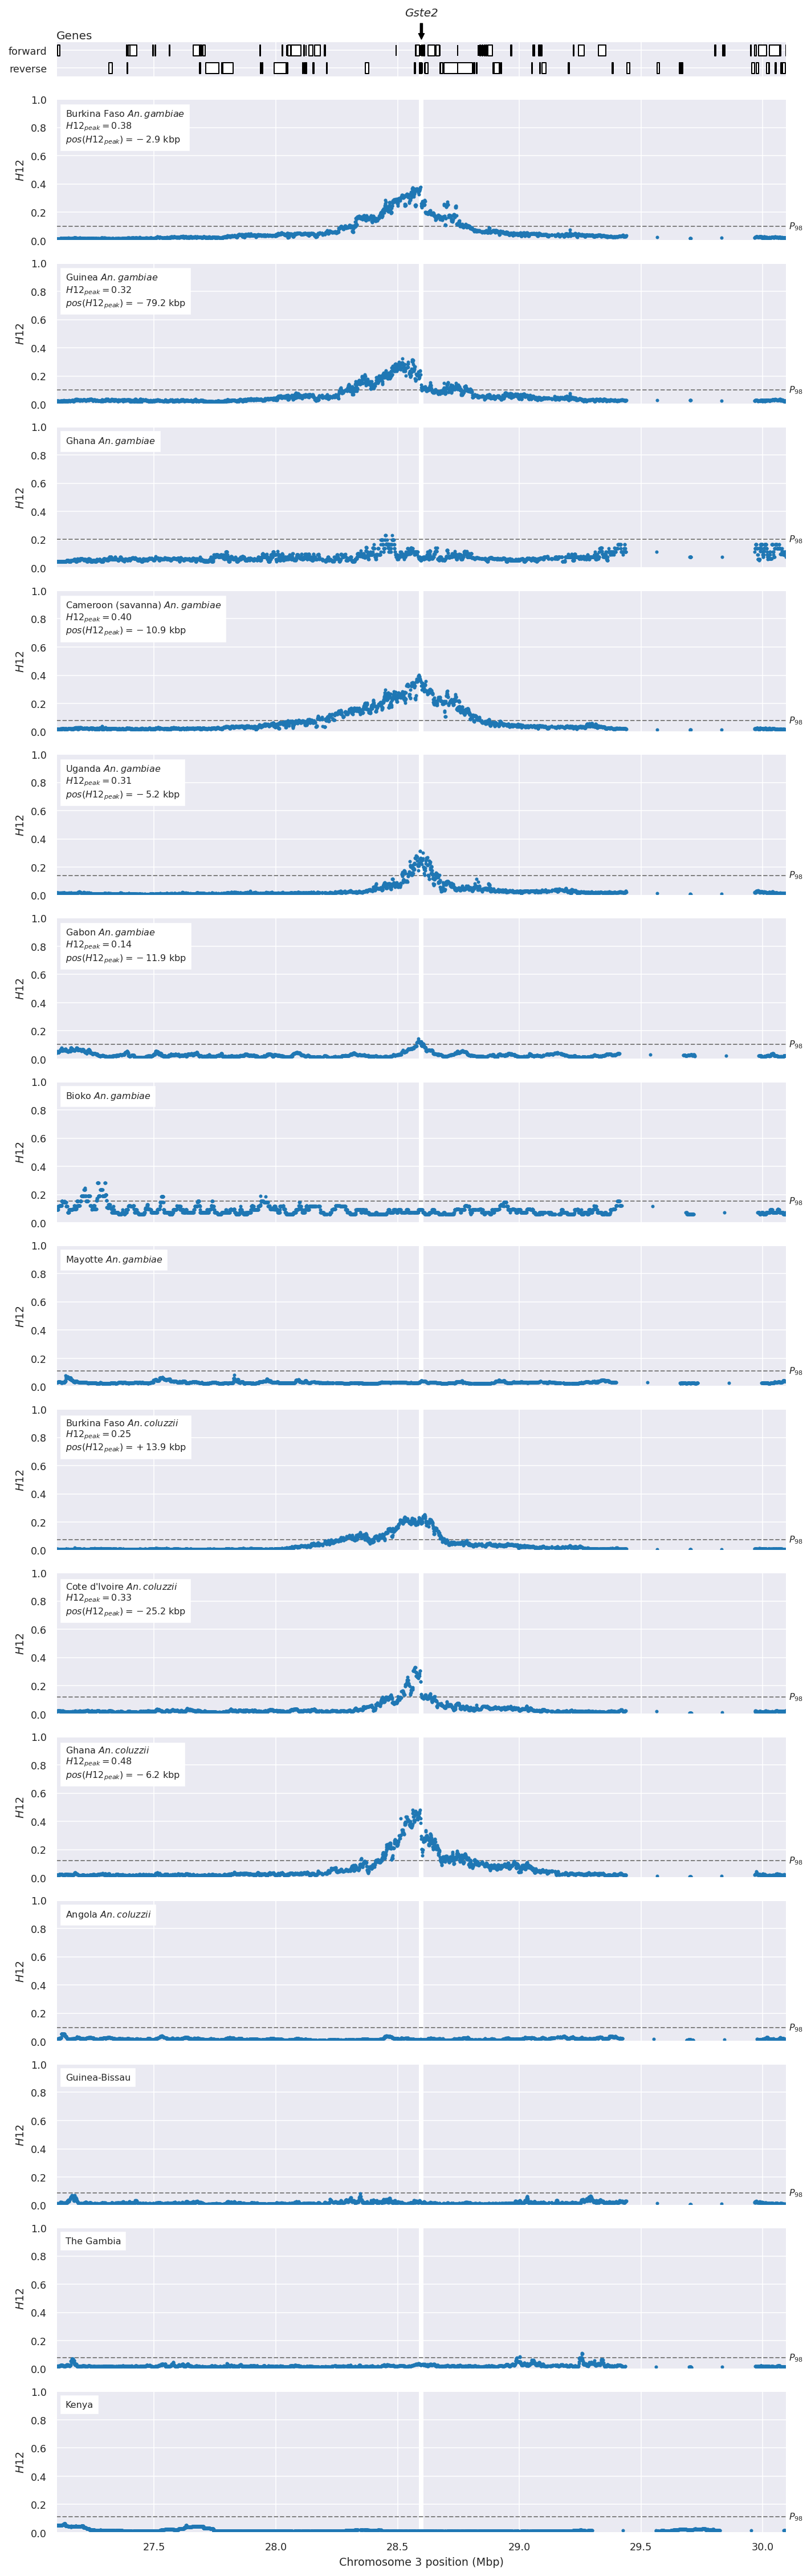

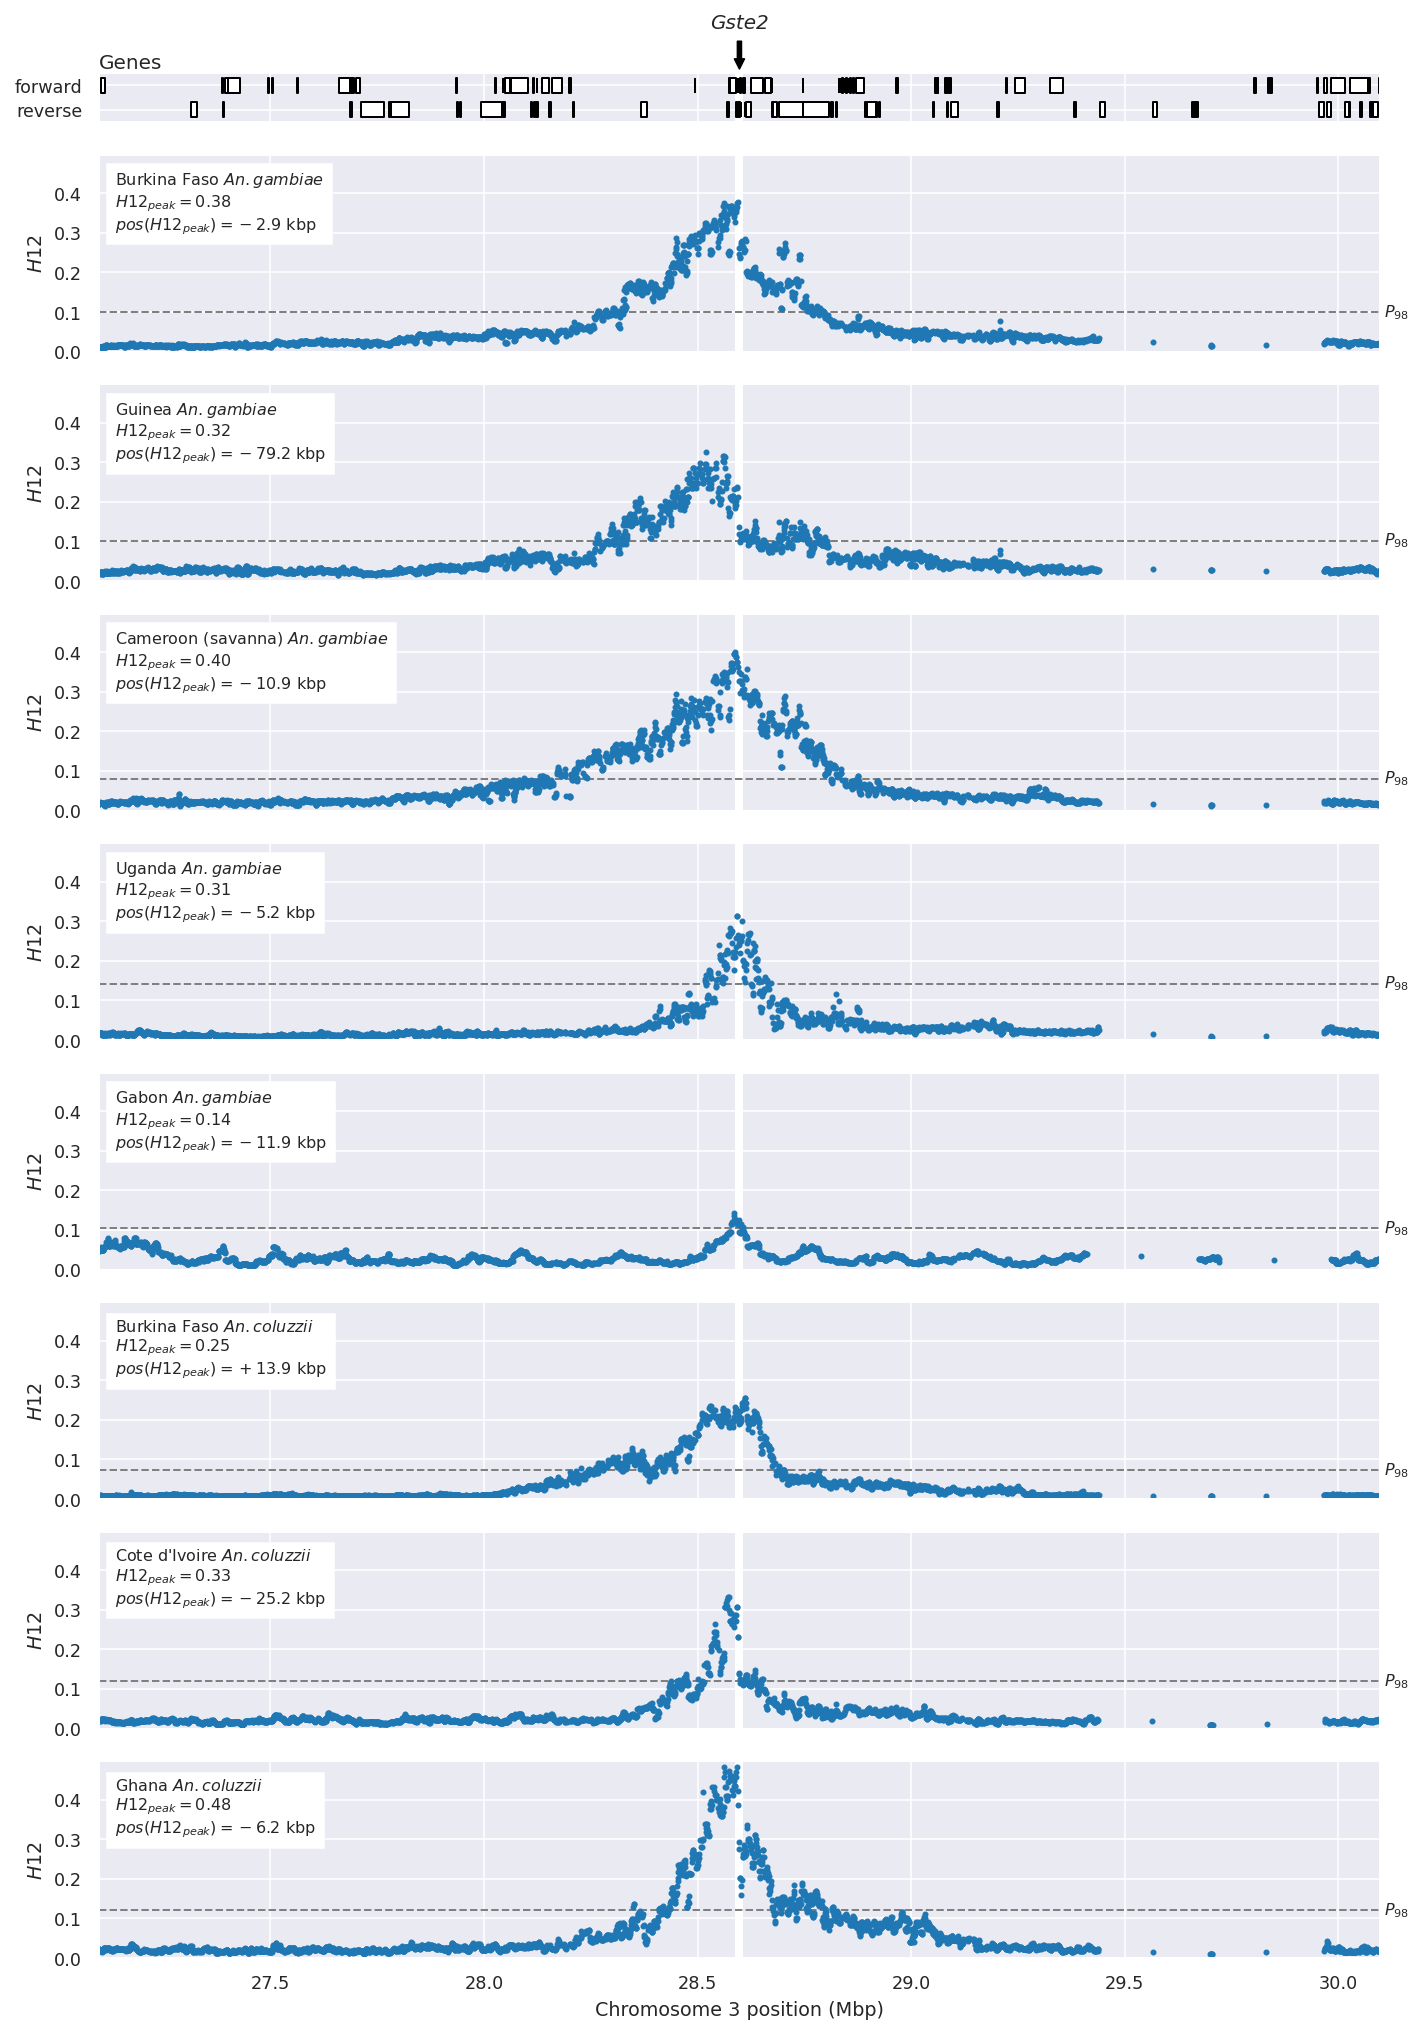

In [128]:
analyse_gene(gste2)

## *Cyp6p3*

In [129]:
cyp6p3

seqid                            2R
source                   VectorBase
type                           gene
start                      28491415
end                        28493141
score                            -1
strand                            -
phase                            -1
Name                         Cyp6p3
biotype              protein_coding
chromosome                        2
chromosome_start           28491415
chromosome_end             28493141
chromosome_center       2.84923e+07
Name: AGAP002865, dtype: object

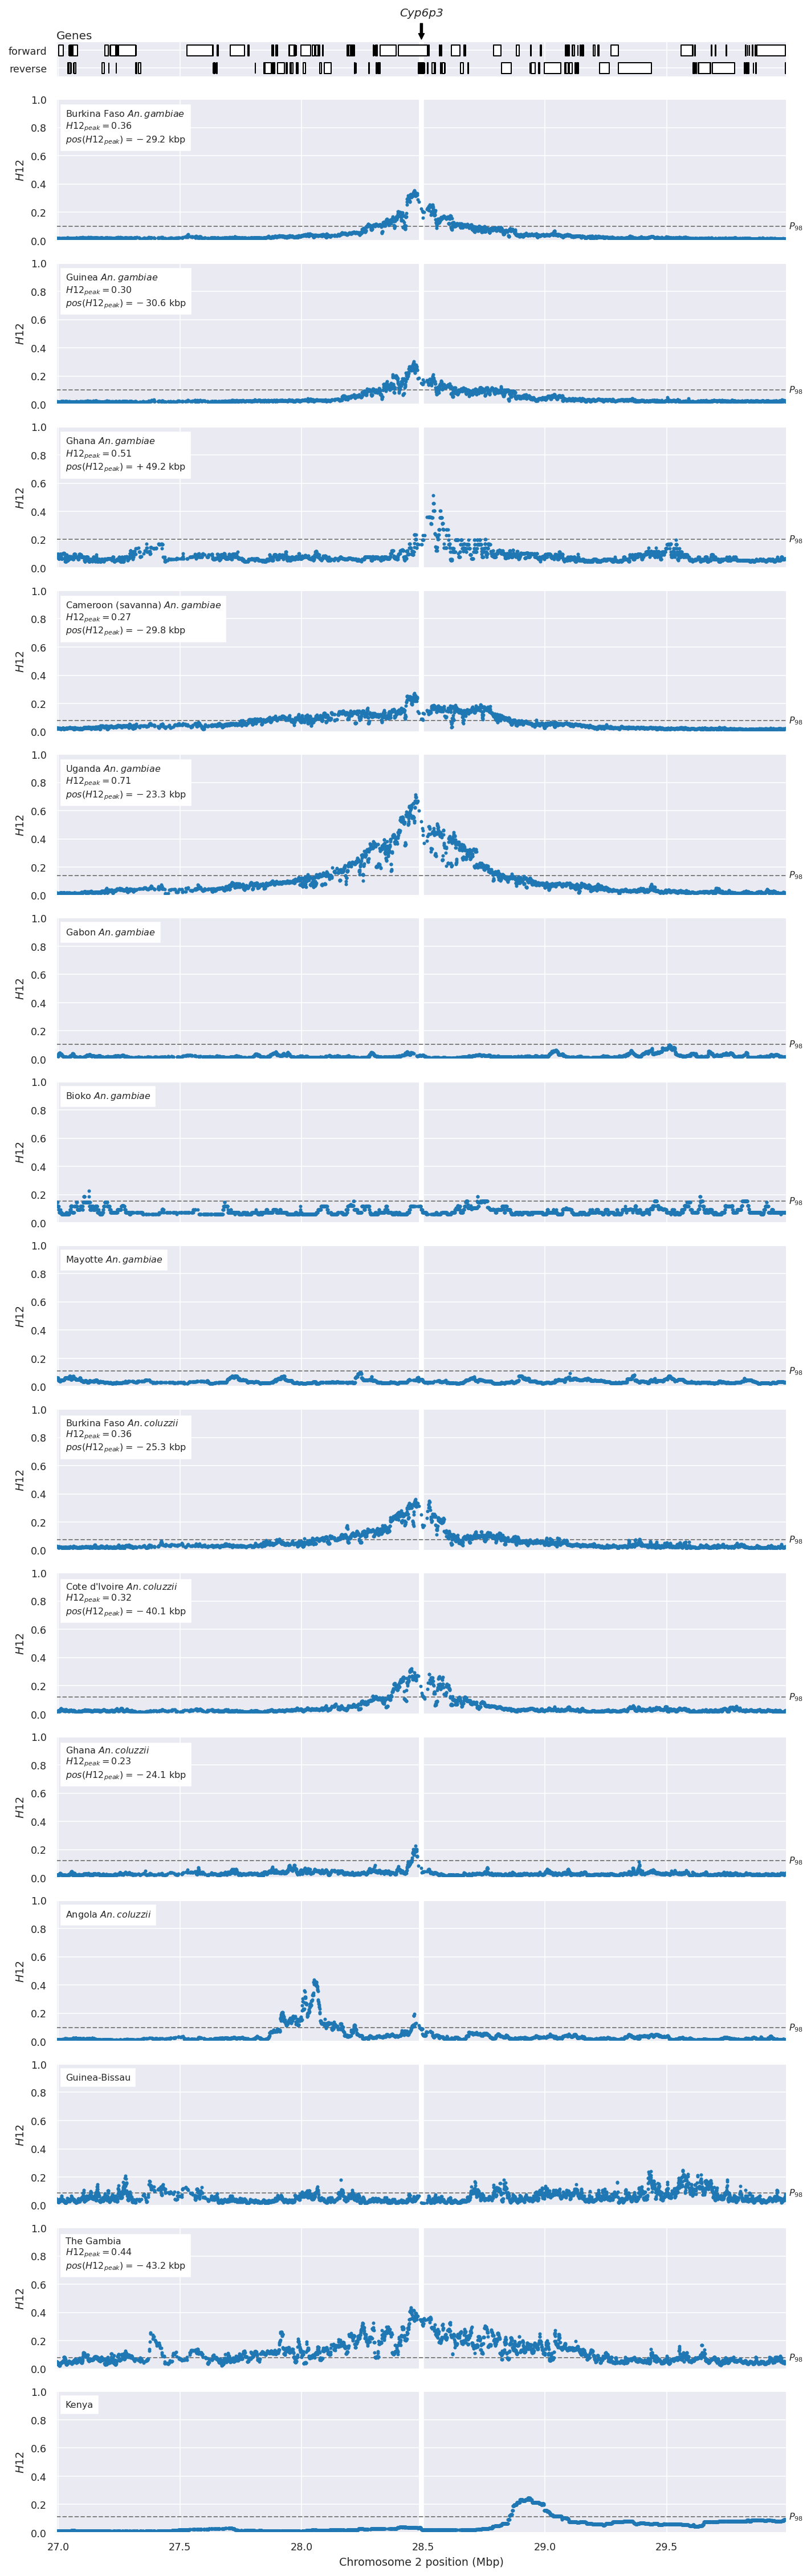

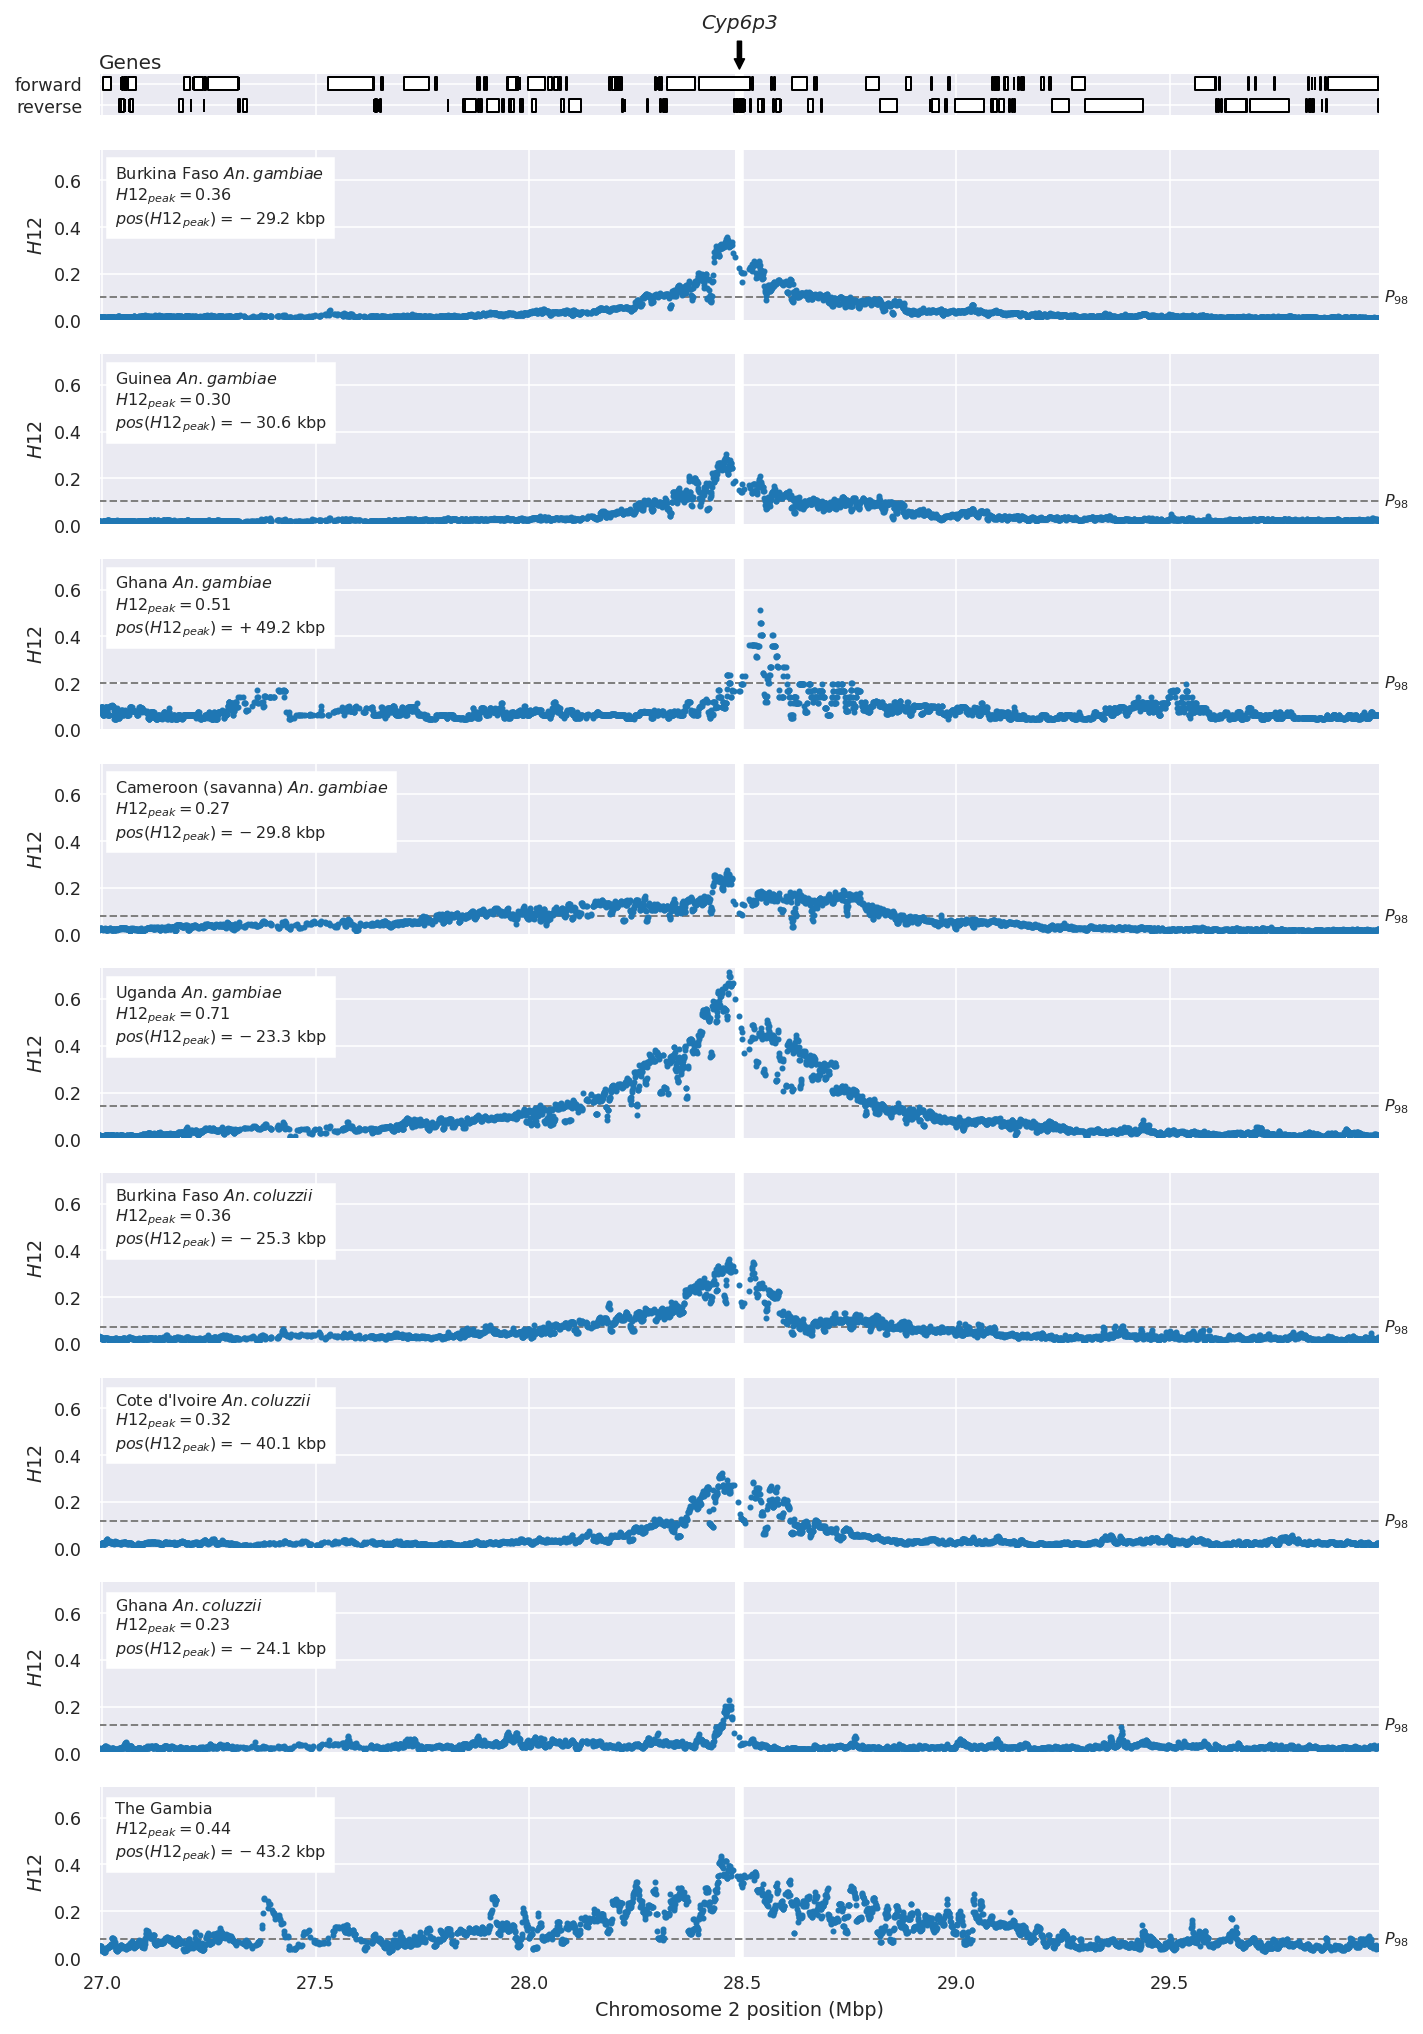

In [130]:
analyse_gene(cyp6p3)

## *Vgsc*

In [131]:
vgsc

seqid                            2L
source                   VectorBase
type                           gene
start                       2358158
end                         2431617
score                            -1
strand                            +
phase                            -1
Name                           Vgsc
biotype              protein_coding
chromosome                        2
chromosome_start           63903263
chromosome_end             63976722
chromosome_center         6.394e+07
Name: AGAP004707, dtype: object

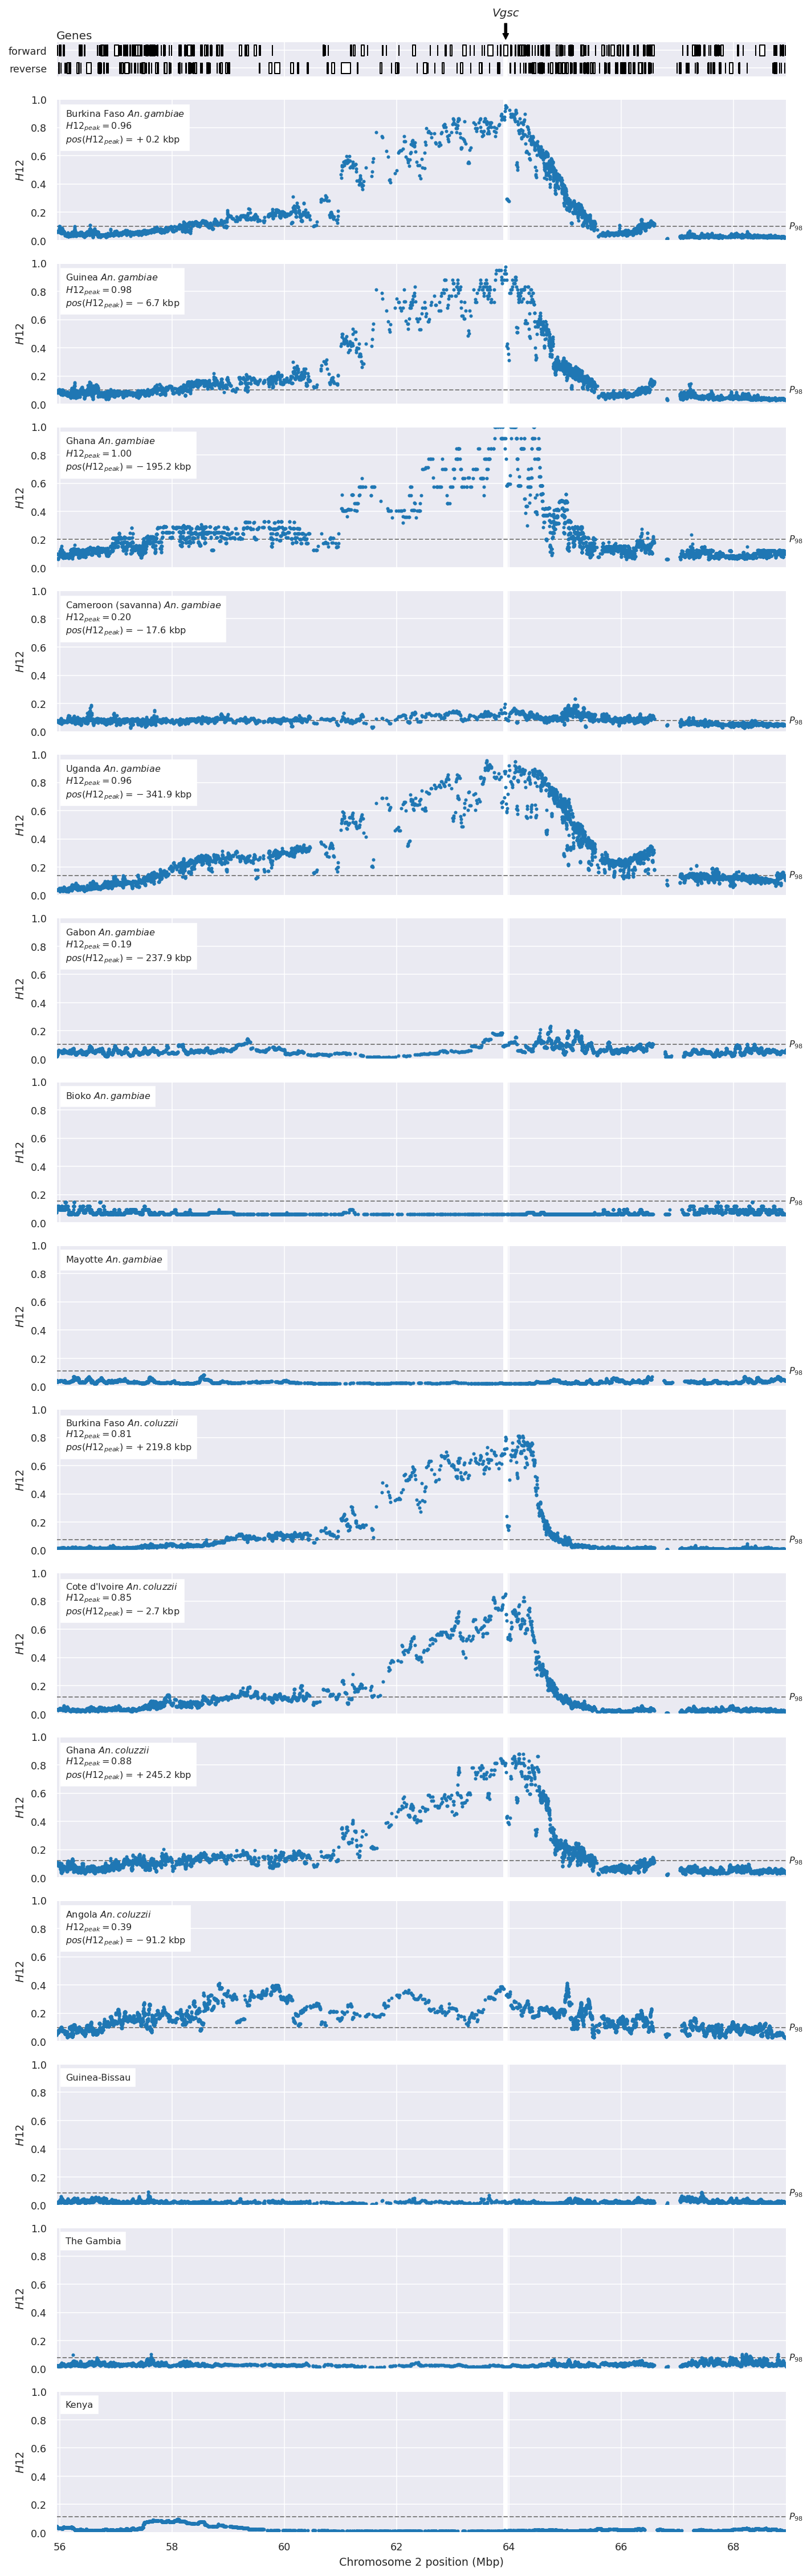

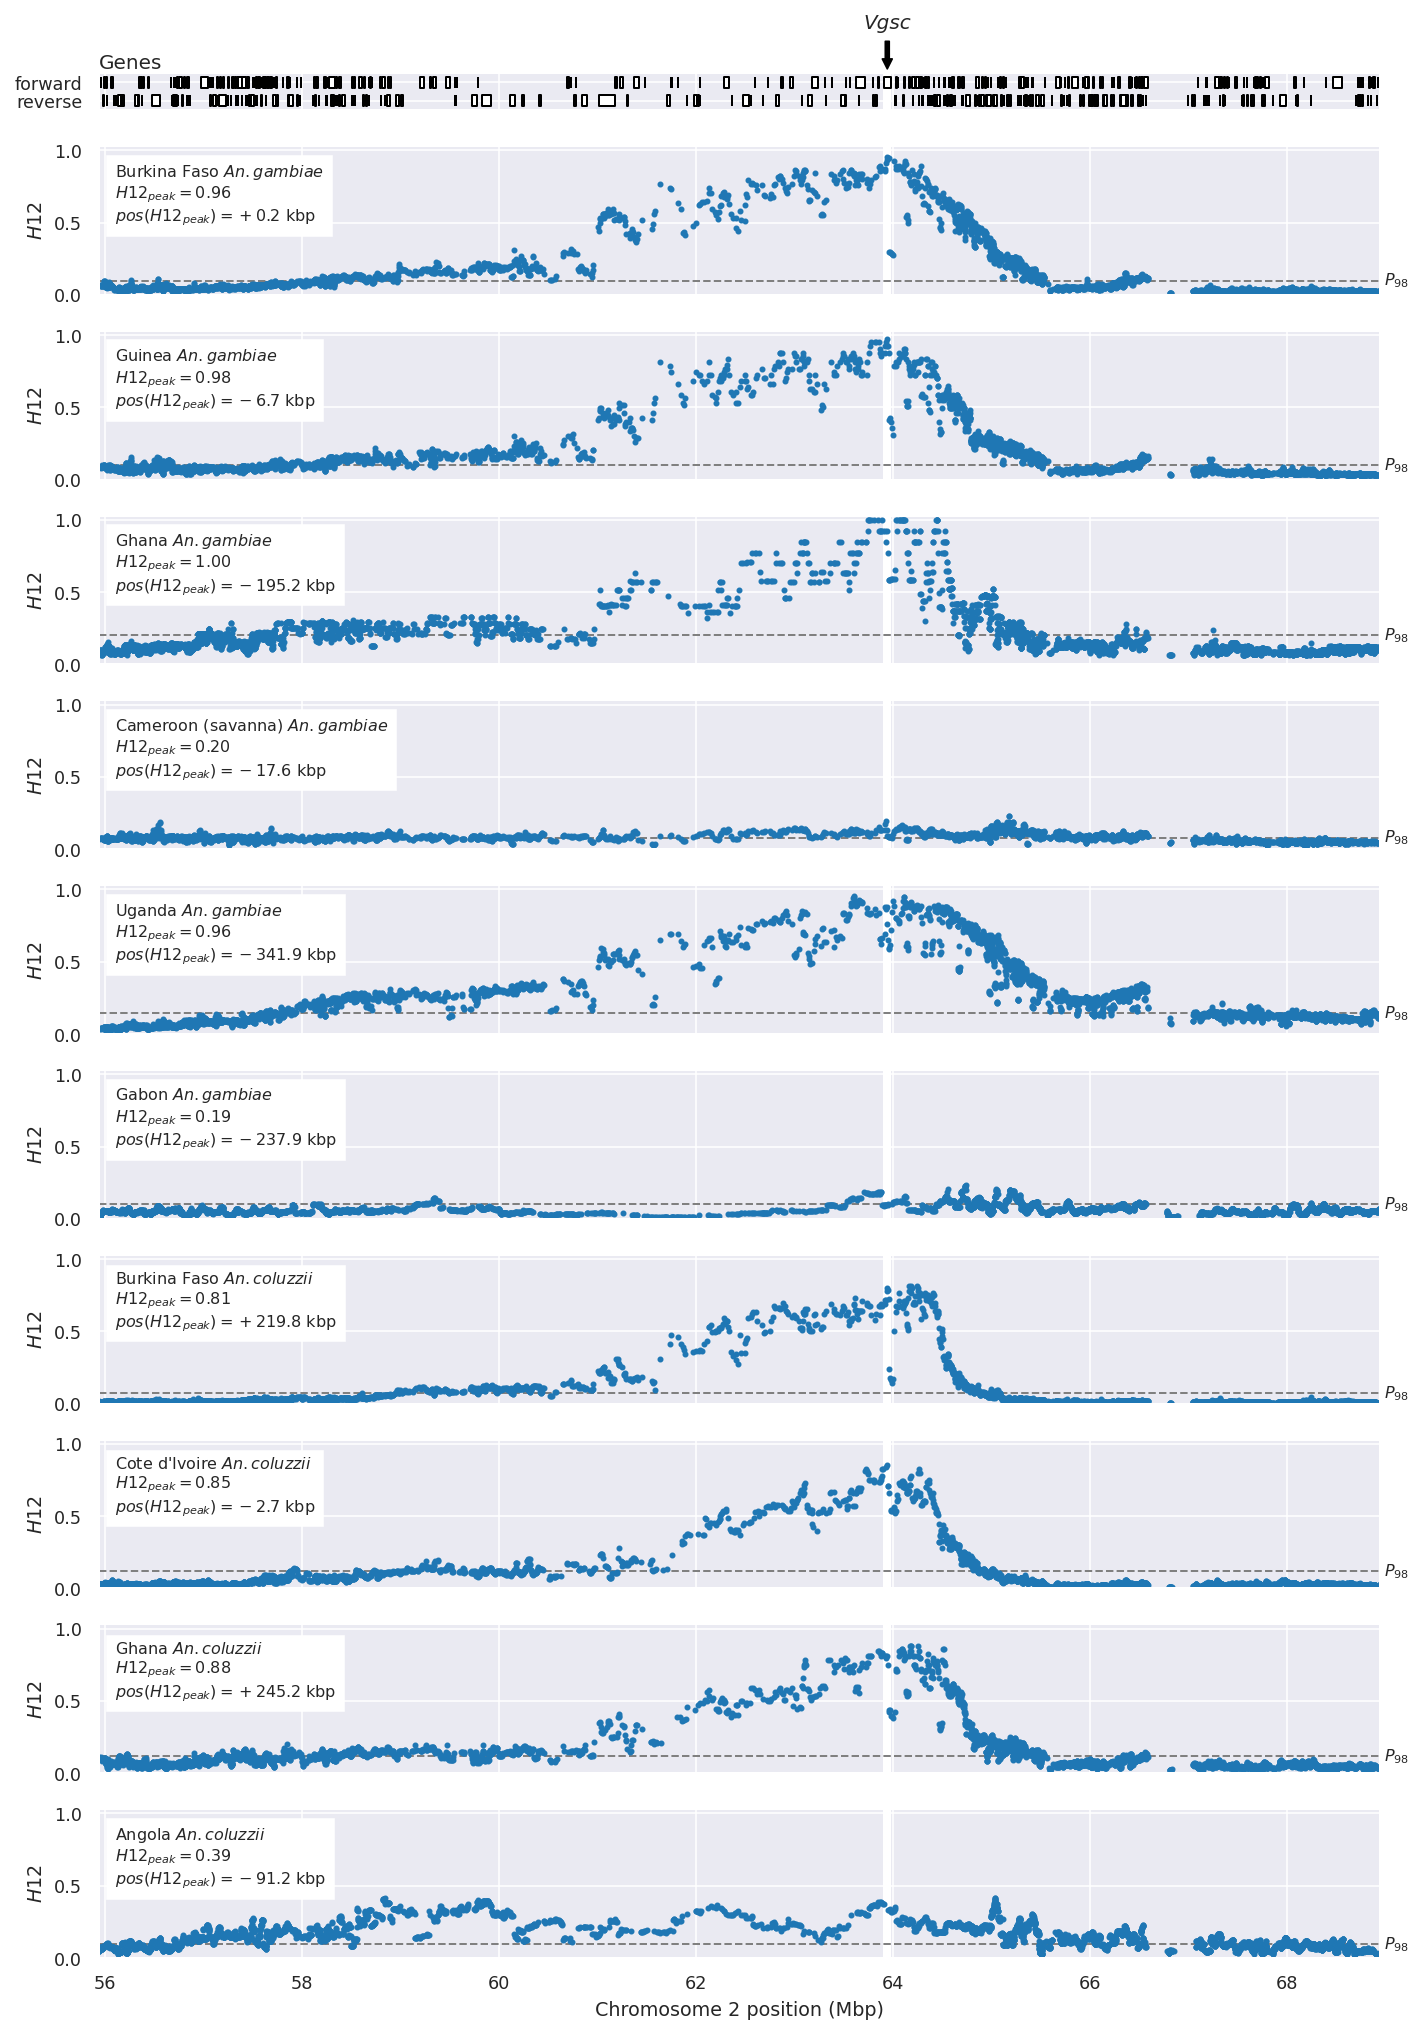

In [132]:
analyse_gene(vgsc, flank=(8, 5))

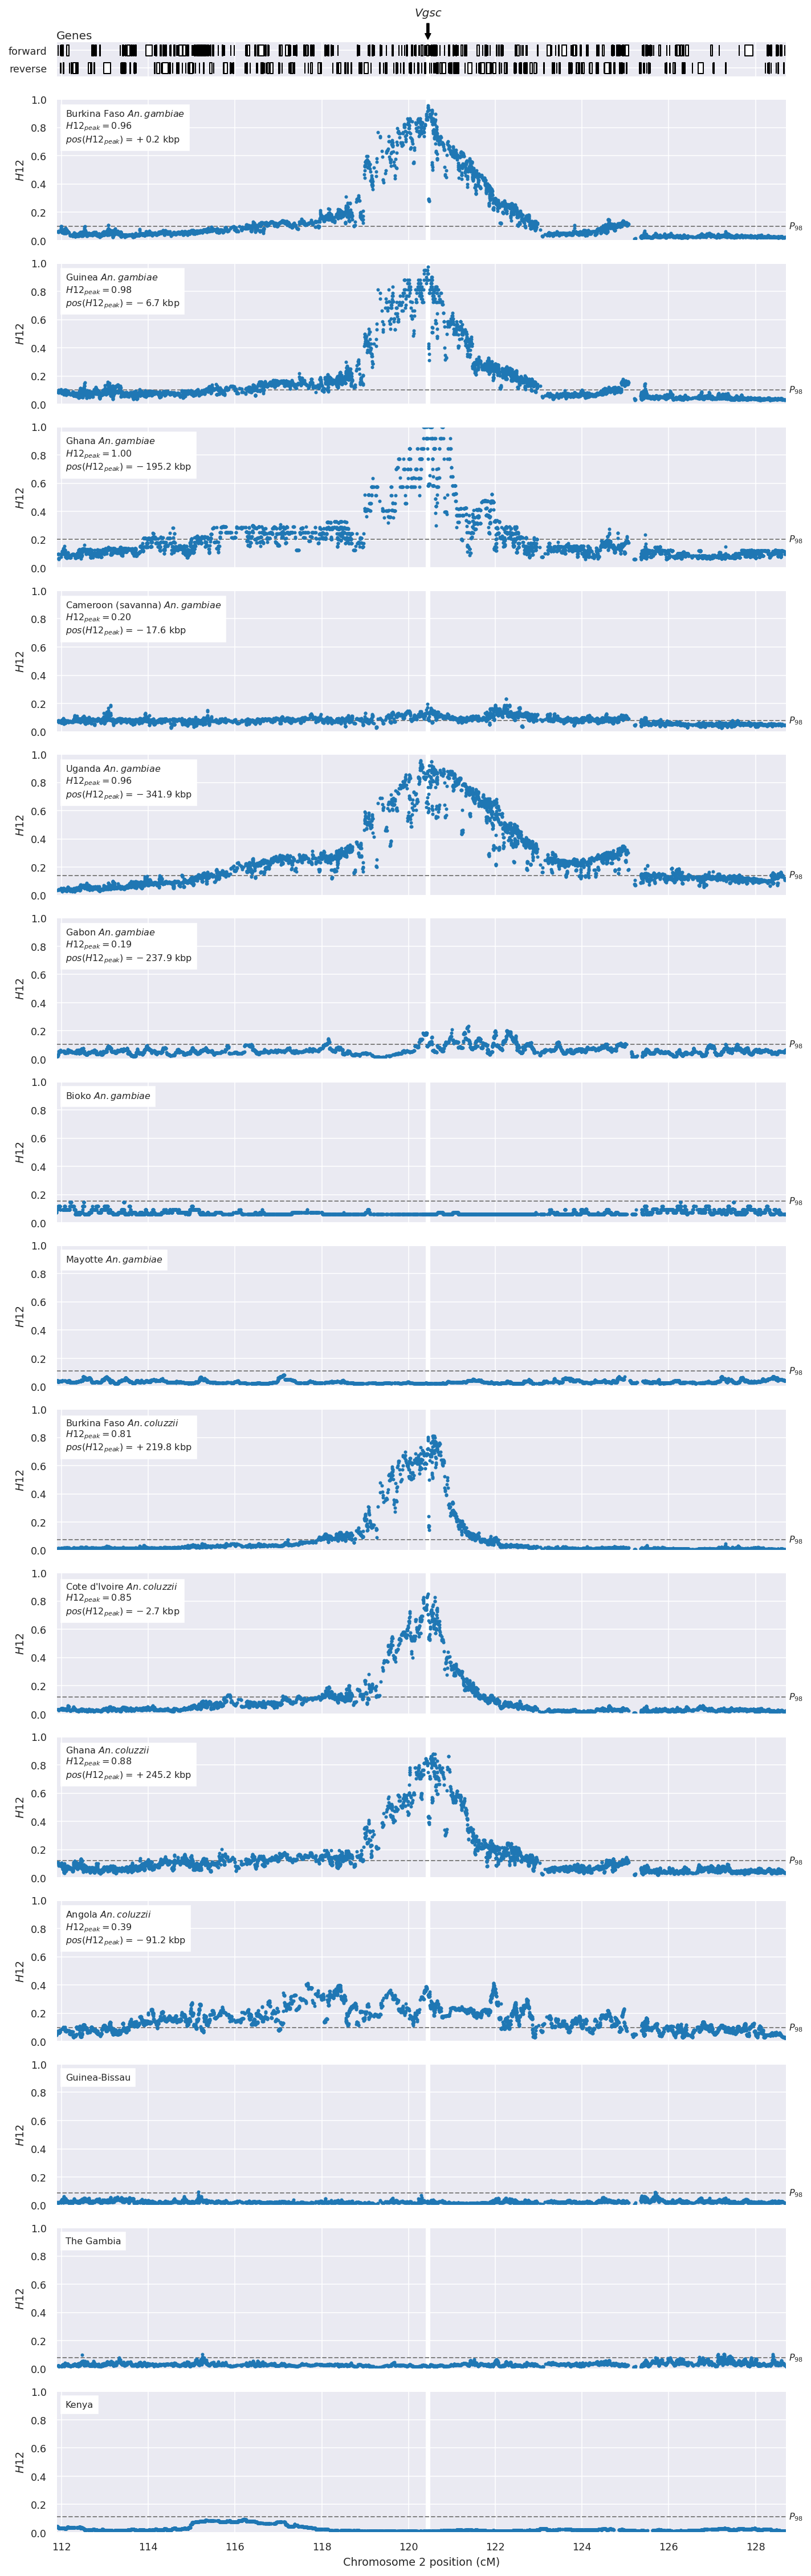

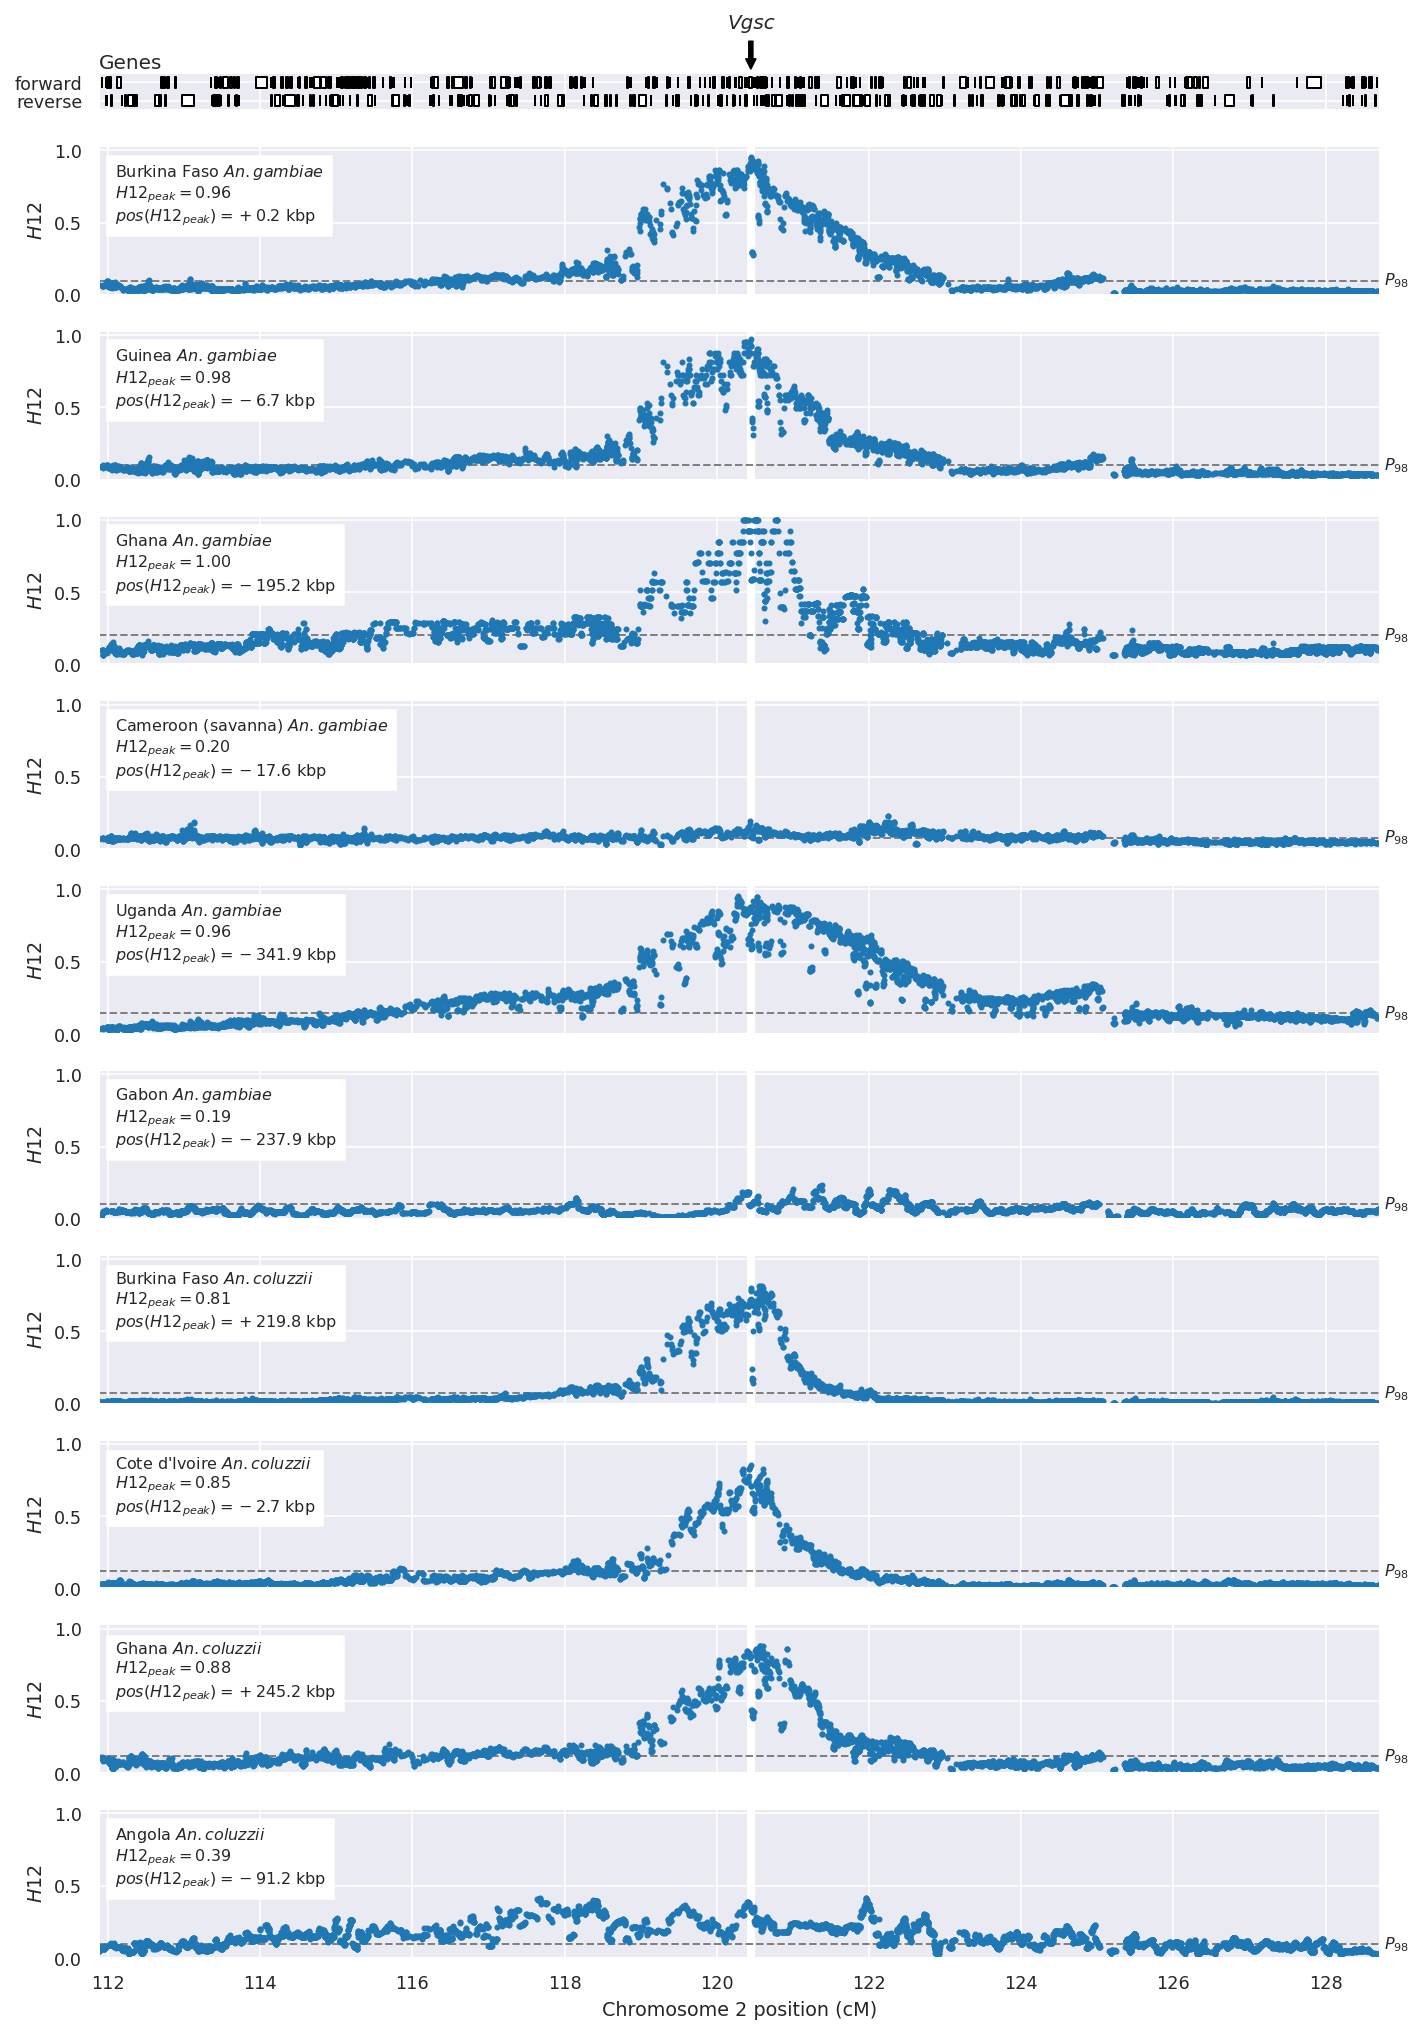

In [133]:
analyse_gene(vgsc, flank=(8, 5), genetic_distance=True)

## *Gaba*

In [134]:
gaba

seqid                            2L
source                   VectorBase
type                           gene
start                      25363652
end                        25434556
score                            -1
strand                            +
phase                            -1
Name                           Gaba
biotype              protein_coding
chromosome                        2
chromosome_start           86908757
chromosome_end             86979661
chromosome_center       8.69442e+07
Name: AGAP006028, dtype: object

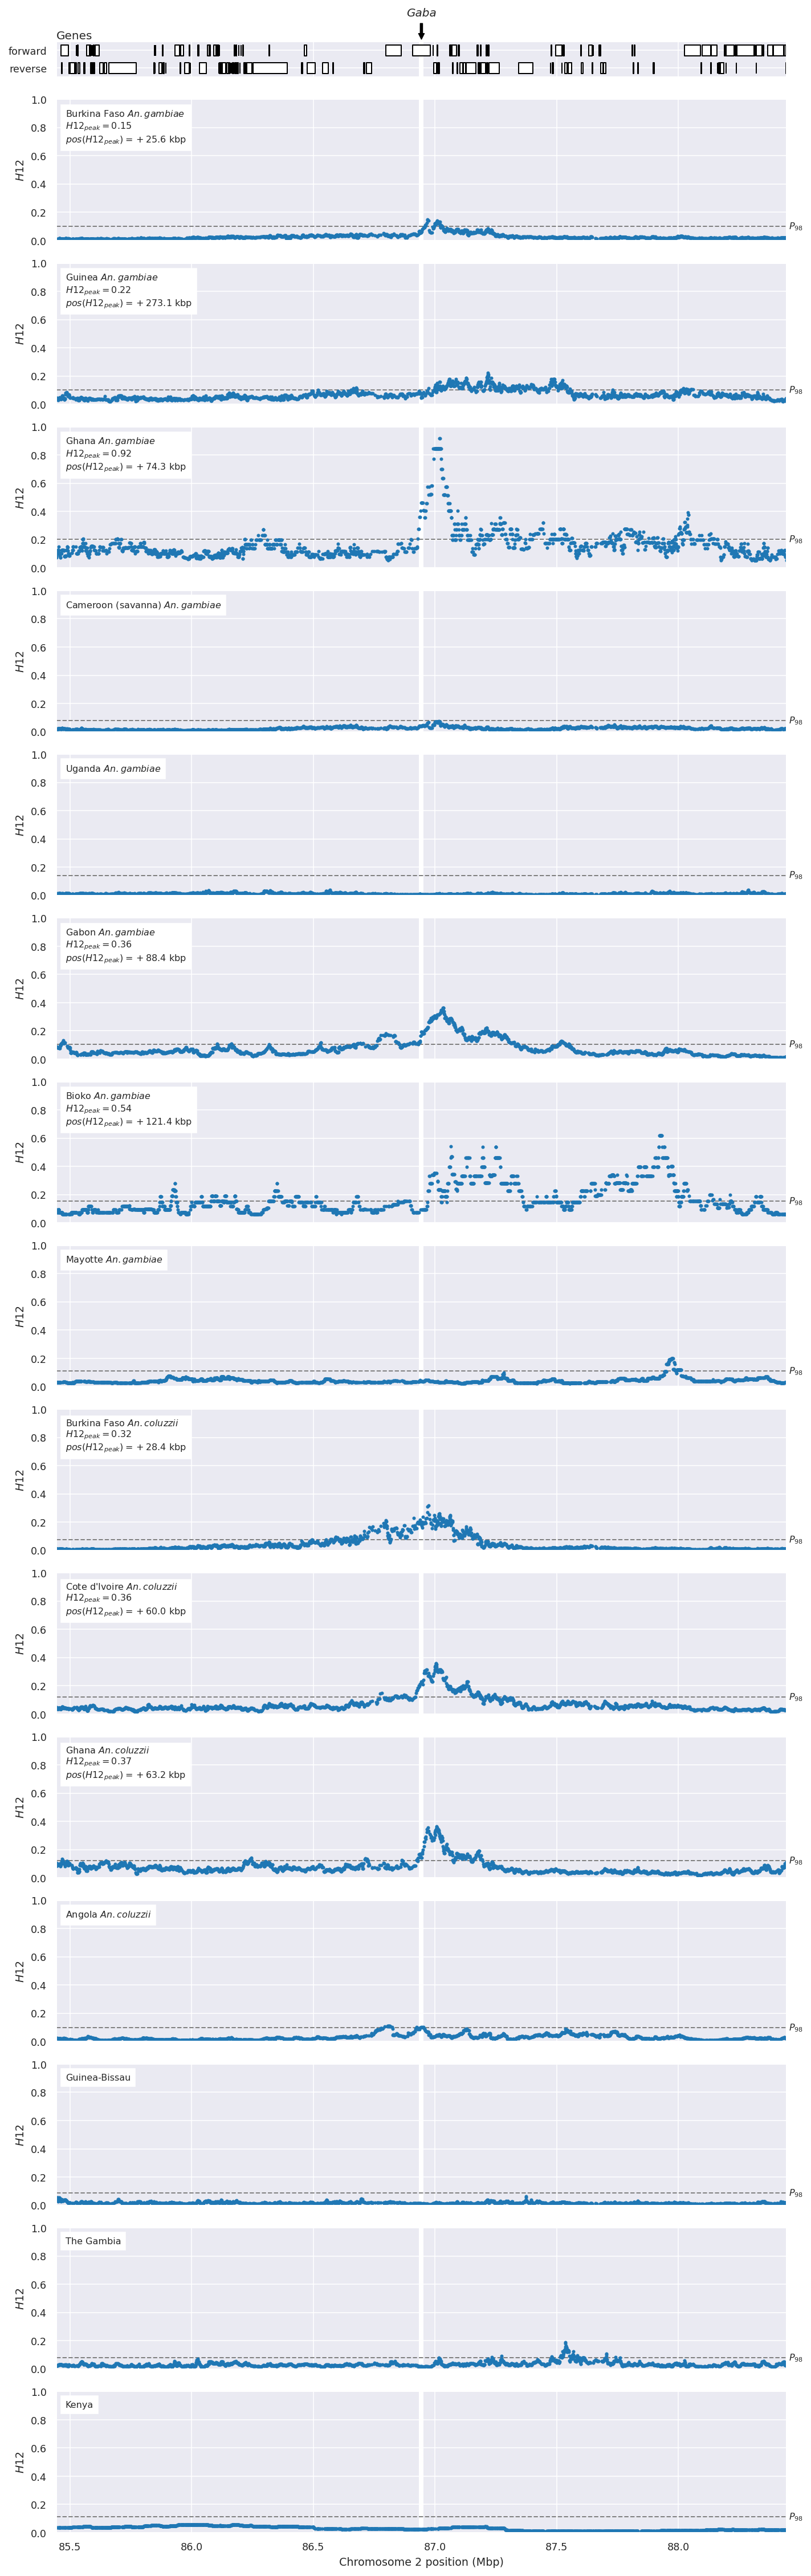

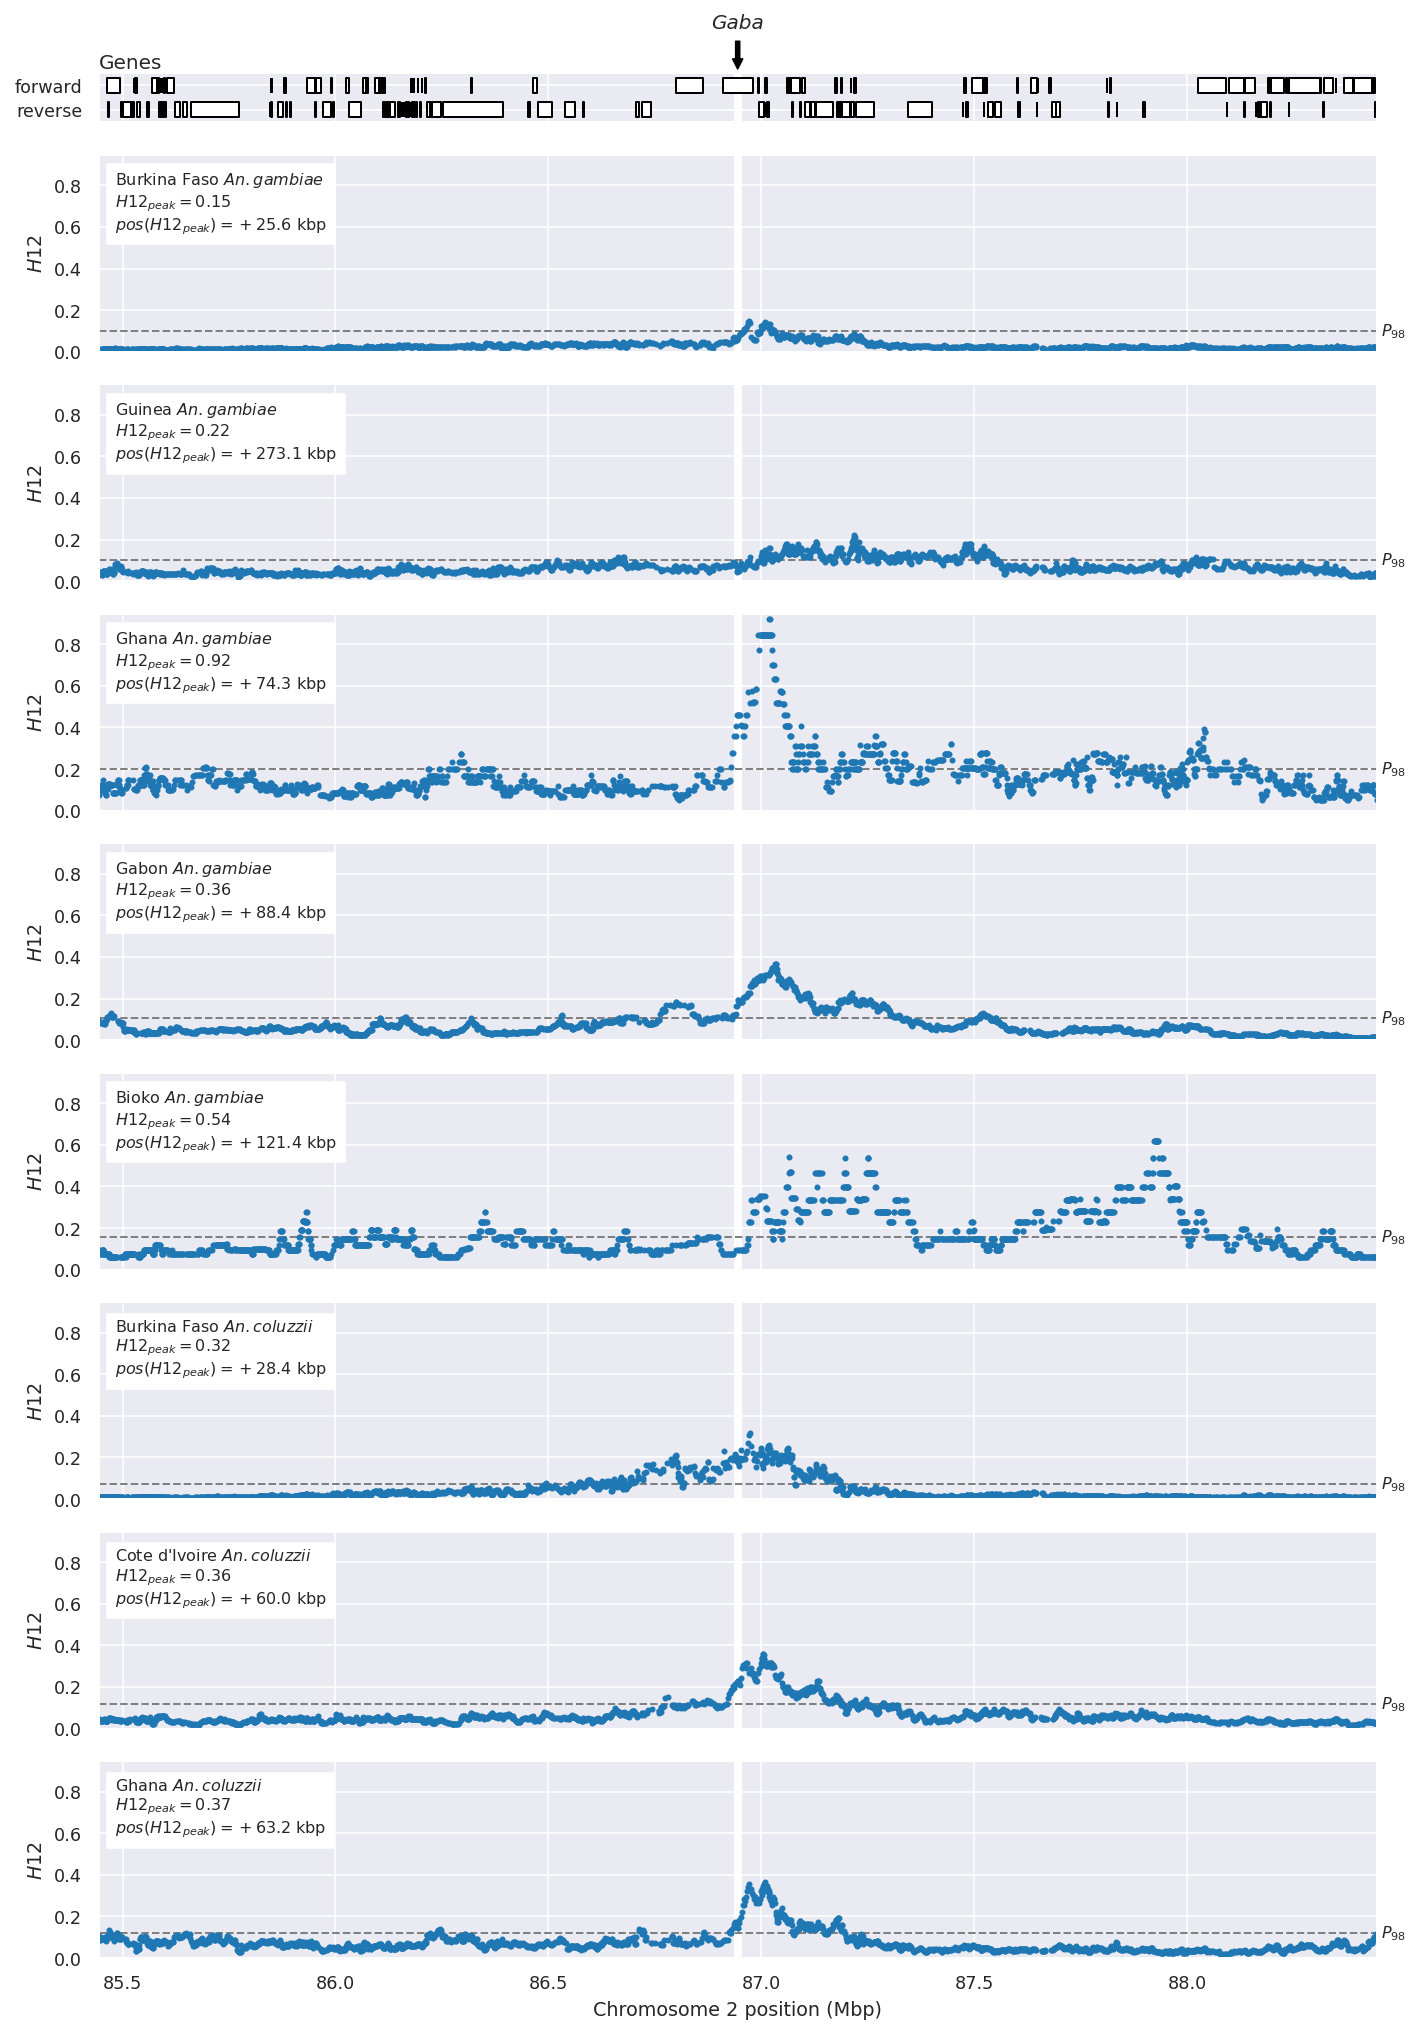

In [135]:
analyse_gene(gaba)

## *Ace1*

In [136]:
ace1

seqid                            2R
source                   VectorBase
type                           gene
start                       3483099
end                         3497400
score                            -1
strand                            +
phase                            -1
Name                           Ace1
biotype              protein_coding
chromosome                        2
chromosome_start            3483099
chromosome_end              3497400
chromosome_center       3.49025e+06
Name: AGAP001356, dtype: object

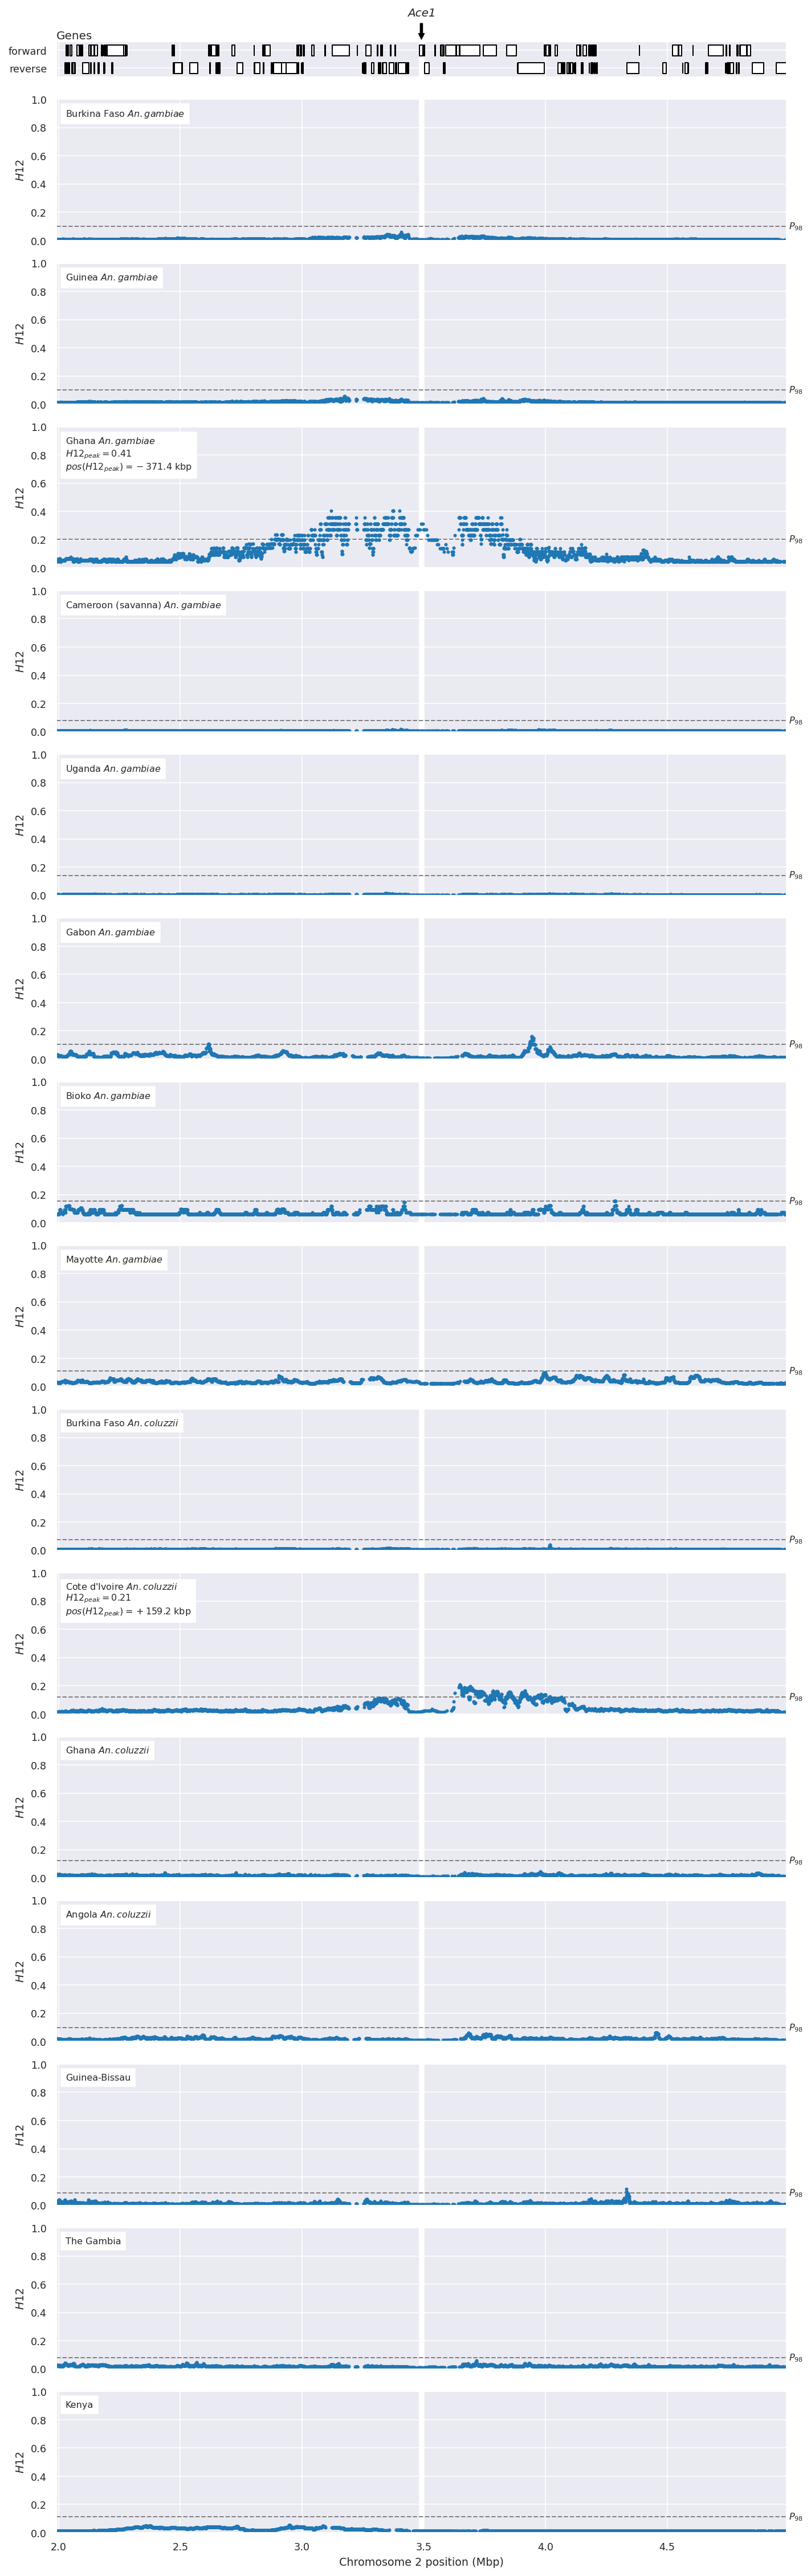

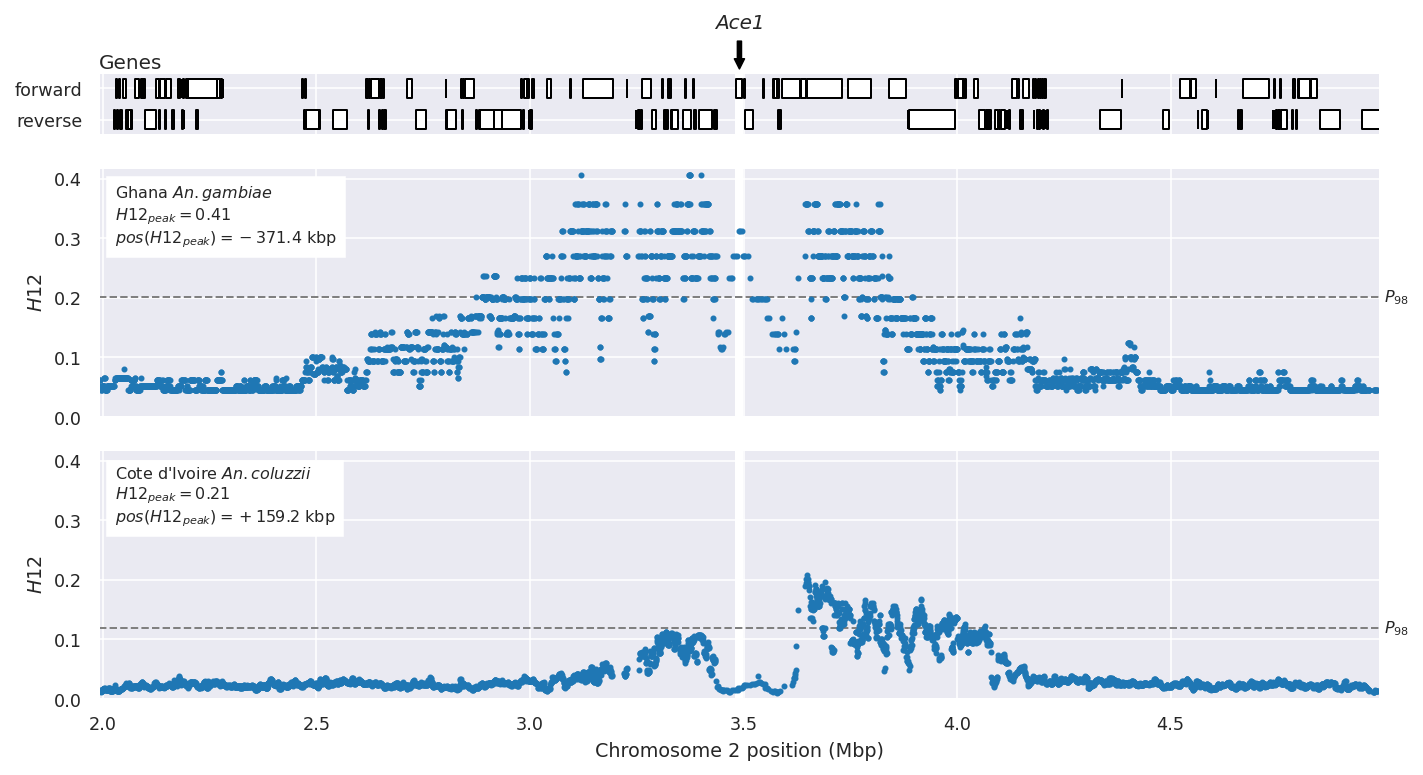

In [137]:
analyse_gene(ace1)

## *Cyp9k1*

In [138]:
cyp9k1

seqid                             X
source                   VectorBase
type                           gene
start                      15240572
end                        15242864
score                            -1
strand                            -
phase                            -1
Name                         Cyp9k1
biotype              protein_coding
chromosome                        X
chromosome_start           15240572
chromosome_end             15242864
chromosome_center       1.52417e+07
Name: AGAP000818, dtype: object

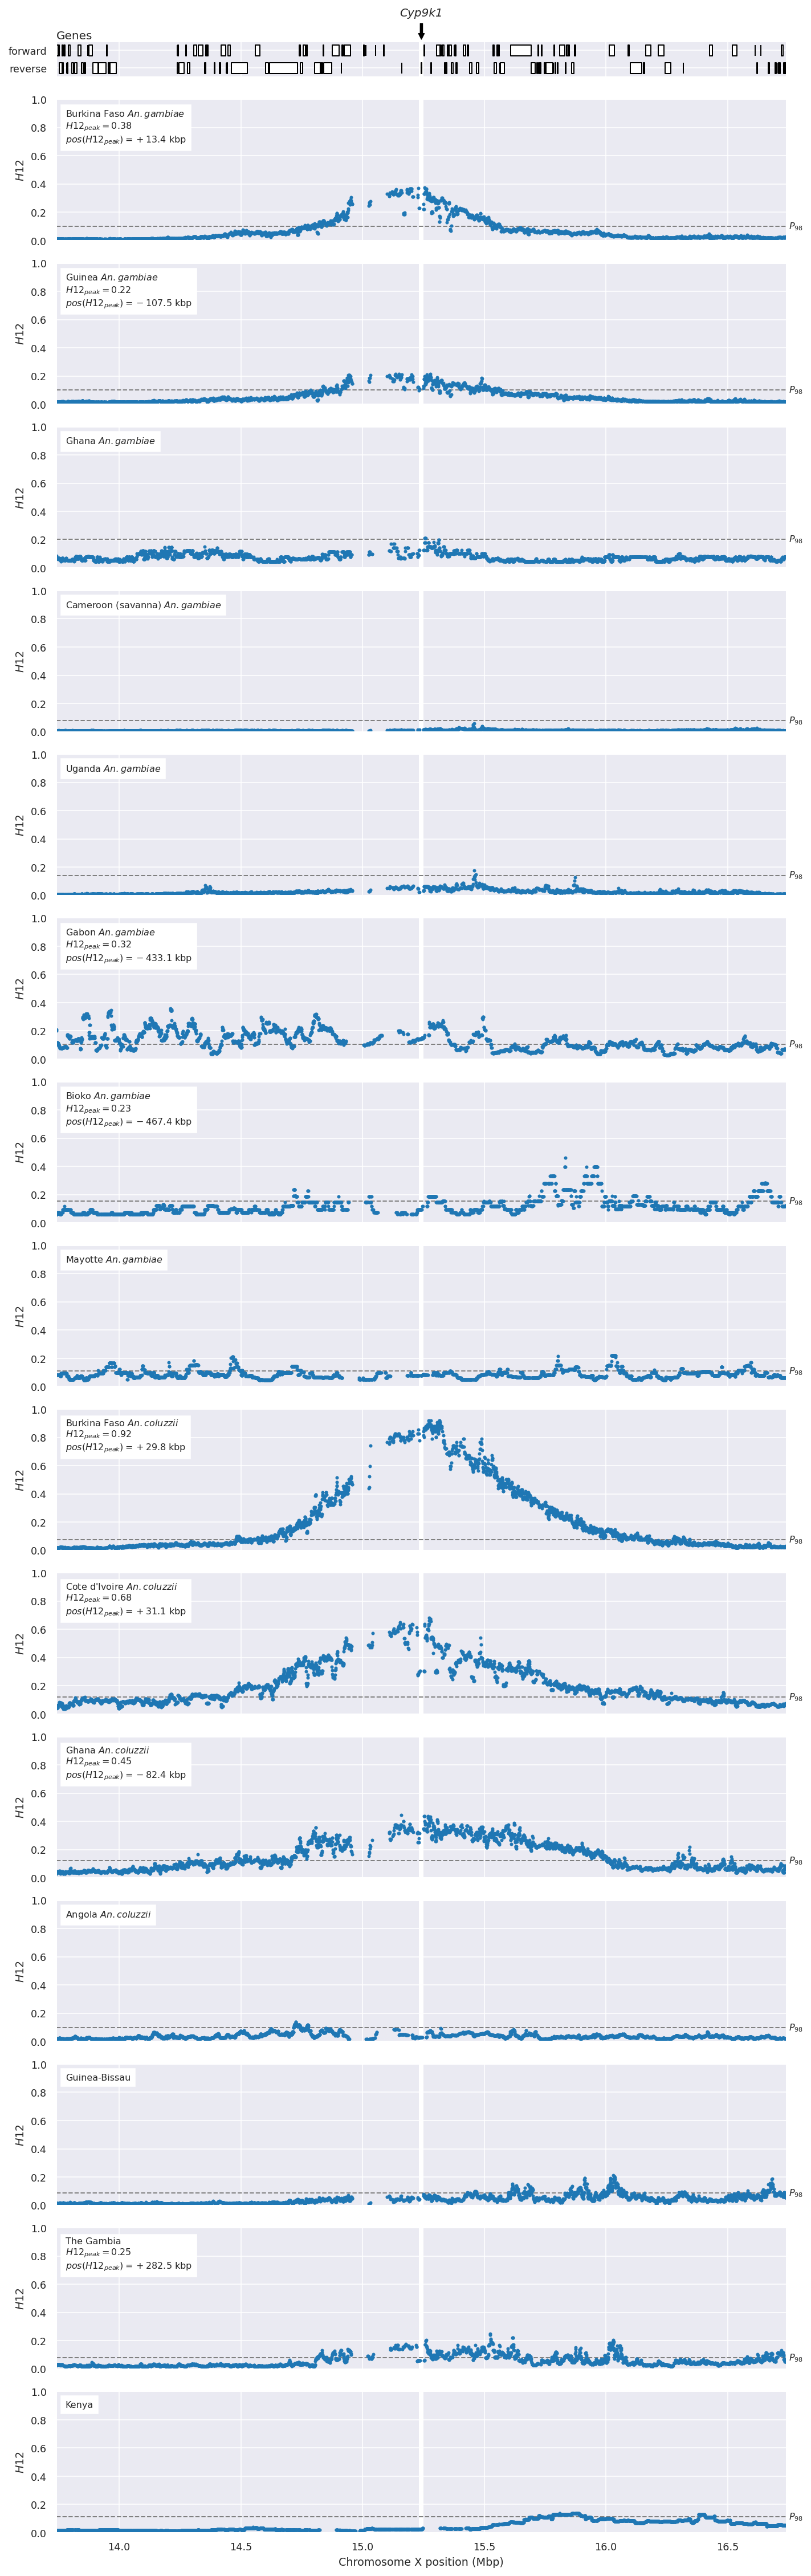

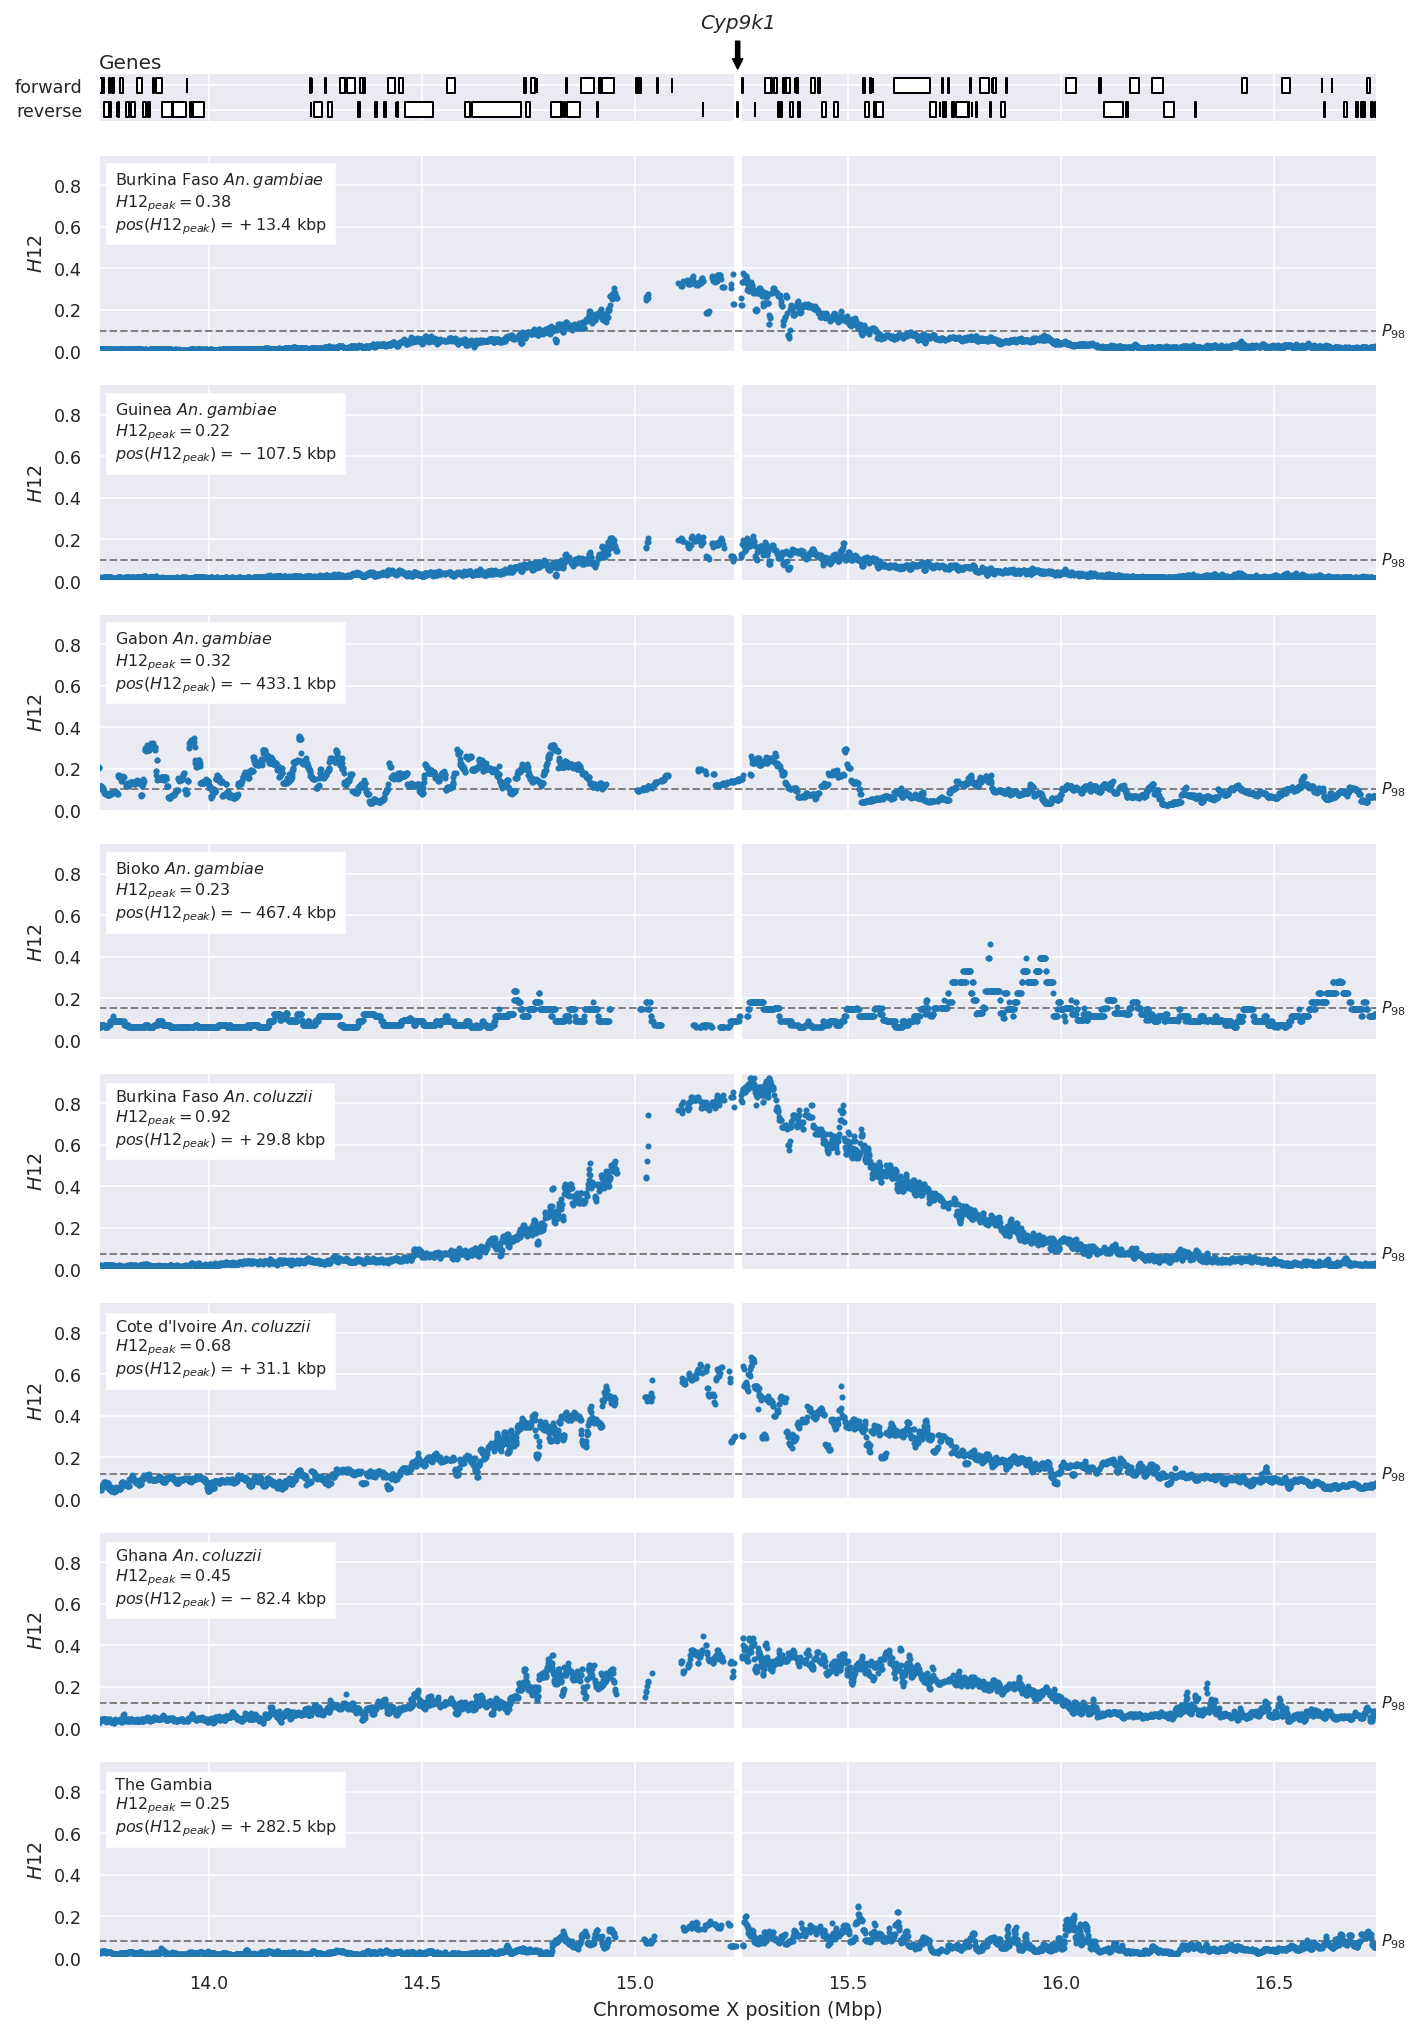

In [139]:
analyse_gene(cyp9k1)

## Compile statistics

In [140]:
df_stats = (
    pd.concat([all_stats[gene['Name'].lower()] 
               for gene in (gste2, cyp6p3, vgsc, gaba, ace1, cyp9k1)])
    [['locus', 'pop', 'h12_peak', 'pos_h12_peak']]
    .dropna()
)
df_stats.loc[:, 'pos_h12_peak'] = df_stats['pos_h12_peak'] * 1e3

In [141]:
def root_mean_square(s):
    return np.sqrt(np.mean(s**2))


def mean_absolute(s):
    return np.mean(np.fabs(s))


In [142]:
df_agg = df_stats.groupby('locus', sort=False).agg({
    'pop': 'count',
    'h12_peak': ['min', 'max'],
    'pos_h12_peak': ['min', 'max', mean_absolute], 
})
df_agg

pop  h12_peak           pos_h12_peak                        
       count       min       max          min       max mean_absolute
locus                                                                
Gste2      8  0.143982  0.482645     -79.2320   13.8750     19.425812
Cyp6p3     9  0.227603  0.714326     -43.2115   49.1705     32.755389
Vgsc      10  0.185465  1.000000    -341.9295  245.2025    135.839850
Gaba       8  0.148098  0.920139      25.6005  273.1255     91.807500
Ace1       2  0.207697  0.406250    -371.4300  159.2125    265.321250
Cyp9k1     8  0.215313  0.918692    -467.4350  282.4605    180.897500

In [143]:
df_agg.reset_index()

locus   pop  h12_peak           pos_h12_peak                        
          count       min       max          min       max mean_absolute
0   Gste2     8  0.143982  0.482645     -79.2320   13.8750     19.425812
1  Cyp6p3     9  0.227603  0.714326     -43.2115   49.1705     32.755389
2    Vgsc    10  0.185465  1.000000    -341.9295  245.2025    135.839850
3    Gaba     8  0.148098  0.920139      25.6005  273.1255     91.807500
4    Ace1     2  0.207697  0.406250    -371.4300  159.2125    265.321250
5  Cyp9k1     8  0.215313  0.918692    -467.4350  282.4605    180.897500

In [144]:
(df_agg
    .reset_index()
    .rename({
        'locus': 'Locus',
        'pop': 'Populations',
        'h12_peak': '$H12_{peak}$',
        'pos_h12_peak': '$pos(H12_{peak})$ (kbp)',
        'count': 'No. with peak',
        'min': 'Min',
        'max': 'Max',
        'mean_absolute': 'MAE',
    }, axis=1)
    .to_latex(
        here() / 'tables/locus_stats_h12.tex',
        escape=False,
        formatters=[
            '\\textit{{{}}}'.format,
            None,
            '{:.2f}'.format,
            '{:.2f}'.format,
            '{:+.1f}'.format,
            '{:+.1f}'.format,
            '{:.1f}'.format,
        ],
        index=False
    )
)